# Preprocessing

Hive query to pull the data:

```beeline --outputformat=csv2 -e "SELECT cvdcus_timestamp_s_3, cvdcus_dcd_sig_n_x_3, cvdcus_dcd_sig_val_str_x_3 FROM cvdp.ncvdcus_bdd_dcd_child_sec_f150_my2019_to_my2020_vw WHERE cvdcus_vin_d_3 == '1FTEW1C53KFB01079' AND cvdcus_dcd_sig_n_x_3 IN ('AirAmb_Te_ActlFilt', 'Outside_Air_Temp_Stat', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'AirCondFluidHi_P_Actl', 'CoolantFanStepAct', 'VehLong2_A_Actl', 'HvacAirCond_B_Rq', 'Veh_V_ActlEng', 'ApedPos_Pc_ActlArb', 'EngAout_N_Actl', 'HvacBlwrFront_D_Stat', 'BattULo_U_Actl', 'GPS_Latitude_Degrees', 'GPS_Longitude_Degrees', 'GearLvrPos_D_Actl', 'Ignition_Status', 'DriverWindowPosition', 'RearPassWindowPos', 'PassWindowPosition', 'BrkTot_Tq_Actl', 'OdometerMasterValue') AND cvdcus_timestamp_s_3 BETWEEN '2019-05-01' and '2019-08-30' ORDER BY cvdcus_timestamp_s_3" > /u/achopra8/2019f150VIN1FTEW1C53KFB01079.csv```

## Pivot Table Construction

In [1]:
import pandas as pd

In [843]:
df = pd.read_csv('2019f150VIN1FTEW1C53KFB01079.csv')
df.head()

cvdcus_timestamp_s_3  cvdcus_dcd_sig_n_x_3 cvdcus_dcd_sig_val_str_x_3
0  2019-05-01 14:40:00.88863        BrkTot_Tq_Actl                      736.0
1  2019-05-01 14:40:00.88947  HvacBlwrFront_D_Stat                        Off
2  2019-05-01 14:40:00.89004         Veh_V_ActlEng                       0.00
3  2019-05-01 14:40:00.89048        BrkTot_Tq_Actl                      732.0
4   2019-05-01 14:40:00.9254     GearLvrPos_D_Actl                       Park

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17896651 entries, 0 to 17896650
Data columns (total 3 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   cvdcus_timestamp_s_3        object
 1   cvdcus_dcd_sig_n_x_3        object
 2   cvdcus_dcd_sig_val_str_x_3  object
dtypes: object(3)
memory usage: 409.6+ MB


In [349]:
df['cvdcus_timestamp_s_3'] = df['cvdcus_timestamp_s_3'].astype('datetime64[ns]') # ensure timestamps are in datetime format
df['cvdcus_timestamp_s_3'] = df['cvdcus_timestamp_s_3'].dt.round('1s') # round to nearest second
#df['epoch'] = df['cvdcus_timestamp_s_3'].astype('int64')/1e9 # add epoch

In [5]:
df.head()

cvdcus_timestamp_s_3  cvdcus_dcd_sig_n_x_3 cvdcus_dcd_sig_val_str_x_3
0  2019-05-01 14:40:01        BrkTot_Tq_Actl                      736.0
1  2019-05-01 14:40:01  HvacBlwrFront_D_Stat                        Off
2  2019-05-01 14:40:01         Veh_V_ActlEng                       0.00
3  2019-05-01 14:40:01        BrkTot_Tq_Actl                      732.0
4  2019-05-01 14:40:01     GearLvrPos_D_Actl                       Park

Since our data is very high frequency, we will group by second and aggregate.

In [350]:
signals = df['cvdcus_dcd_sig_n_x_3'].unique()
dtypes = [float, str, float, str, float, float, float, float, str, float, float, str, float, float, float, float, float, str, float, str, str, str]
agg_funcs = ['mean' if dtype == float else pd.Series.mode for dtype in dtypes] # functions to aggregate each signal by

In [351]:
def df_by_sig(signals=signals, dtypes=dtypes, agg_funcs=agg_funcs):
    grouped_by_sig = []
    for i in range(len(signals)):
        try:
            temp = df[df['cvdcus_dcd_sig_n_x_3'] == signals[i]]
            temp['cvdcus_dcd_sig_val_str_x_3'] = temp['cvdcus_dcd_sig_val_str_x_3'].astype(dtypes[i])
            temp = temp.groupby(['cvdcus_timestamp_s_3', 'cvdcus_dcd_sig_n_x_3']).agg(agg_funcs[i]).reset_index()
            temp = temp.rename(columns={'cvdcus_dcd_sig_val_str_x_3':temp['cvdcus_dcd_sig_n_x_3'].iloc[0]}).drop('cvdcus_dcd_sig_n_x_3', axis=1)
            grouped_by_sig.append(temp)
        except ValueError as err:
            grouped_by_sig.append('Fail')
            print('{}: {}'.format(signals[i], err))
    return grouped_by_sig
dfs_grouped_by_sig = df_by_sig()

C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


GPS_Longitude_Degrees: could not convert string to float: 'Fault'
GPS_Latitude_Degrees: could not convert string to float: 'Invalid'
Outside_Air_Temp_Stat: could not convert string to float: 'Invalid'
VehLong2_A_Actl: could not convert string to float: 'NoDataExists'


In [55]:
# remove rows w/ bad input as shown above
df = df.drop(df[(df['cvdcus_dcd_sig_n_x_3'].isin(['GPS_Longitude_Degrees', 'GPS_Latitude_Degrees', 'Outside_Air_Temp_Stat', 'VehLong2_A_Actl'])) & (df['cvdcus_dcd_sig_val_str_x_3'].isin(['Fault', 'Invalid', 'NoDataExists']))].index).reset_index(drop=True)
dfs_grouped_by_sig = df_by_sig()



C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
pivotted = pd.concat([df.set_index('cvdcus_timestamp_s_3') for df in dfs_grouped_by_sig], axis=1).reset_index()
pivotted.head()

cvdcus_timestamp_s_3  BrkTot_Tq_Actl HvacBlwrFront_D_Stat  Veh_V_ActlEng  \
0  2019-05-01 14:40:01      742.666667                  Off            0.0   
1  2019-05-01 14:40:02     2094.000000                  NaN            0.0   
2  2019-05-01 14:40:03     2702.074074                  NaN            0.0   
3  2019-05-01 14:40:04     2725.655172                  NaN            0.0   
4  2019-05-01 14:40:05     2410.736842                  NaN            0.0   

  GearLvrPos_D_Actl  ApedPos_Pc_ActlArb  EngAout_N_Actl  HvacEvap_Te_Actl  \
0              Park                 0.0             0.0              21.5   
1              Park                 0.0             0.0              21.5   
2              Park                 0.0             0.0              21.5   
3              Park                 0.0             0.0              21.5   
4              Park                 0.0             0.0              21.5   

   HvacEvap_Te_Rq HvacAirCond_B_Rq  ...  GPS_Longitude_Degrees  \
0             8.0               No  ...                  -81.0   
1             8.0               No  ...                  -81.0   
2             8.0               No  ...                    NaN   
3             8.0               No  ...                    NaN   
4             8.0               No  ...                    NaN   

   GPS_Latitude_Degrees AirAmb_Te_ActlFilt  Outside_Air_Temp_Stat  \
0                  30.0                NaN                    NaN   
1                  30.0               19.0                   10.0   
2                   NaN               19.0                   10.0   
3                   NaN               19.0                   10.0   
4                   NaN               19.0                   10.0   

   OdometerMasterValue  Ignition_Status  VehLong2_A_Actl  RearPassWindowPos  \
0                  NaN              NaN              NaN                NaN   
1               2707.0              NaN              NaN                NaN   
2               2707.0              Off              NaN                NaN   
3               2707.0              Off              NaN                NaN   
4               2707.0              NaN              NaN                NaN   

  DriverWindowPosition  PassWindowPosition  
0                  NaN                 NaN  
1                  NaN                 NaN  
2                  NaN                 NaN  
3                  NaN                 NaN  
4                  NaN                 NaN  

[5 rows x 23 columns]

In [213]:
# store pivot table in csv to avoid expensive computations above
pivotted.to_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted.csv', index=False)

## Quality Control

- [Data Loading & Quality Control](#loading_quality)
- [Definining Trips](#trip)
- [Objective Statement](#objectives)
    - [Gap Between Actual and Requested Temperature](#gap_analysis)
    - [Duration that Compressor Temperature is < 0°C](#dur_neg)

In [430]:
import pandas as pd
pivotted = pd.read_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted.csv')

In [431]:
pivotted['cvdcus_timestamp_s_3'] = pd.to_datetime(pivotted['cvdcus_timestamp_s_3'])
pivotted['epoch'] = pivotted['cvdcus_timestamp_s_3'].astype('int64')/1e9
cols = pivotted.columns.to_list()
pivotted = pivotted[[cols[0]] + [cols[-1]] + cols[1:-1]]
pivotted.head()

cvdcus_timestamp_s_3         epoch  BrkTot_Tq_Actl HvacBlwrFront_D_Stat  \
0  2019-05-01 14:40:01  1.556722e+09      742.666667                  Off   
1  2019-05-01 14:40:02  1.556722e+09     2094.000000                  NaN   
2  2019-05-01 14:40:03  1.556722e+09     2702.074074                  NaN   
3  2019-05-01 14:40:04  1.556722e+09     2725.655172                  NaN   
4  2019-05-01 14:40:05  1.556722e+09     2410.736842                  NaN   

   Veh_V_ActlEng GearLvrPos_D_Actl  ApedPos_Pc_ActlArb  EngAout_N_Actl  \
0            0.0              Park                 0.0             0.0   
1            0.0              Park                 0.0             0.0   
2            0.0              Park                 0.0             0.0   
3            0.0              Park                 0.0             0.0   
4            0.0              Park                 0.0             0.0   

   HvacEvap_Te_Actl  HvacEvap_Te_Rq  ... GPS_Longitude_Degrees  \
0              21.5             8.0  ...                 -81.0   
1              21.5             8.0  ...                 -81.0   
2              21.5             8.0  ...                   NaN   
3              21.5             8.0  ...                   NaN   
4              21.5             8.0  ...                   NaN   

   GPS_Latitude_Degrees  AirAmb_Te_ActlFilt Outside_Air_Temp_Stat  \
0                  30.0                 NaN                   NaN   
1                  30.0                19.0                  10.0   
2                   NaN                19.0                  10.0   
3                   NaN                19.0                  10.0   
4                   NaN                19.0                  10.0   

   OdometerMasterValue  Ignition_Status  VehLong2_A_Actl  RearPassWindowPos  \
0                  NaN              NaN              NaN                NaN   
1               2707.0              NaN              NaN                NaN   
2               2707.0              Off              NaN                NaN   
3               2707.0              Off              NaN                NaN   
4               2707.0              NaN              NaN                NaN   

   DriverWindowPosition PassWindowPosition  
0                   NaN                NaN  
1                   NaN                NaN  
2                   NaN                NaN  
3                   NaN                NaN  
4                   NaN                NaN  

[5 rows x 24 columns]

In [432]:
pivotted = pivotted.drop(['GPS_Longitude_Degrees', 'GPS_Latitude_Degrees'], axis=1) # no longer need GPS coordinates

Below, we can see the fraction of non-null values for each feature. Signals related to window position and ignition status seem to be bad quality and have many missing values; we should keep this in mind during imputation.

In [415]:
pivotted.count()/pivotted.shape[0]

cvdcus_timestamp_s_3     1.000000
epoch                    1.000000
BrkTot_Tq_Actl           0.960546
HvacBlwrFront_D_Stat     0.170500
Veh_V_ActlEng            0.921270
GearLvrPos_D_Actl        0.924367
ApedPos_Pc_ActlArb       0.968305
EngAout_N_Actl           0.968305
HvacEvap_Te_Actl         0.700753
HvacEvap_Te_Rq           0.700753
HvacAirCond_B_Rq         0.700753
BattULo_U_Actl           0.927658
AirCondFluidHi_P_Actl    0.378541
CoolantFanStepAct        0.378541
AirAmb_Te_ActlFilt       0.598652
Outside_Air_Temp_Stat    0.580573
OdometerMasterValue      0.580573
Ignition_Status          0.298716
VehLong2_A_Actl          0.851206
RearPassWindowPos        0.046081
DriverWindowPosition     0.046081
PassWindowPosition       0.046081
dtype: float64

**Heatmap With Numerical Features**

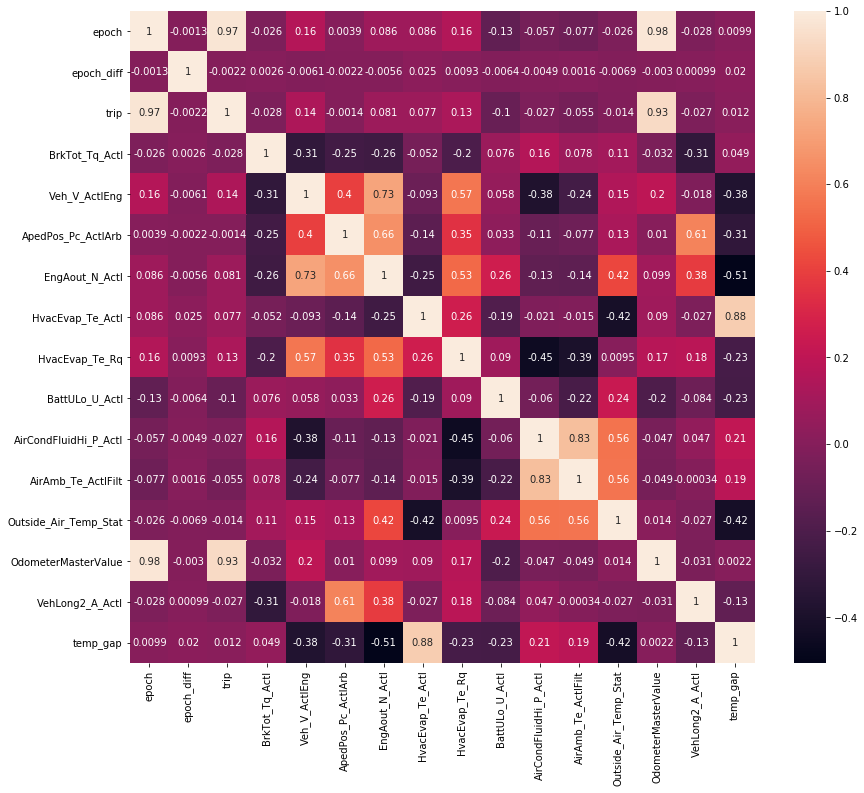

In [449]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = pivotted.corr()
# mask = np.zeros_like(corr_matrix, dtype=np.bool) # if lower triangular matrix preferred
# mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(14, 12)) 
heatmap = sns.heatmap(corr_matrix,annot=True)
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

<a id='trip'></a>
### Defining Trips

In [433]:
pivotted['epoch_diff'] = pivotted['epoch'].diff() # add col to show diff between epoch
cols = list(pivotted.columns)
pivotted = pivotted[cols[0:2] + [cols[-1]] + cols[2:-1]]

Let's define a trip by an interval where the difference between epoch is < 1800 (30 minutes). 

In [434]:
# make empty col that will flag trips
pivotted['trip'] = float('nan')
cols = list(pivotted.columns)
pivotted = pivotted[cols[0:3] + [cols[-1]] + cols[3:-1]]

In [435]:
# add flags to indicate trips
trip_flag = 1
for i in [0] + list(pivotted[pivotted['epoch_diff'] > 1800].index):
    pivotted.loc[i, 'trip'] = trip_flag
    trip_flag += 1
pivotted['trip'] = pivotted['trip'].fillna(method='ffill')
pivotted['trip'] = pivotted['trip'].astype(int)

In [436]:
pivotted

cvdcus_timestamp_s_3         epoch  epoch_diff  trip  BrkTot_Tq_Actl  \
0       2019-05-01 14:40:01  1.556722e+09         NaN     1      742.666667   
1       2019-05-01 14:40:02  1.556722e+09         1.0     1     2094.000000   
2       2019-05-01 14:40:03  1.556722e+09         1.0     1     2702.074074   
3       2019-05-01 14:40:04  1.556722e+09         1.0     1     2725.655172   
4       2019-05-01 14:40:05  1.556722e+09         1.0     1     2410.736842   
...                     ...           ...         ...   ...             ...   
184411  2019-07-26 03:22:41  1.564111e+09         1.0   145        0.000000   
184412  2019-07-26 03:22:42  1.564111e+09         1.0   145        0.000000   
184413  2019-07-26 03:22:43  1.564111e+09         1.0   145        0.000000   
184414  2019-07-26 03:22:44  1.564111e+09         1.0   145        0.000000   
184415  2019-07-26 03:22:45  1.564111e+09         1.0   145        0.000000   

       HvacBlwrFront_D_Stat  Veh_V_ActlEng GearLvrPos_D_Actl  \
0                       Off            0.0              Park   
1                       NaN            0.0              Park   
2                       NaN            0.0              Park   
3                       NaN            0.0              Park   
4                       NaN            0.0              Park   
...                     ...            ...               ...   
184411                  Off            NaN               NaN   
184412                  NaN            NaN               NaN   
184413                  NaN            NaN               NaN   
184414                  NaN            NaN               NaN   
184415                  NaN            NaN               NaN   

        ApedPos_Pc_ActlArb  EngAout_N_Actl  ...  AirCondFluidHi_P_Actl  \
0                      0.0             0.0  ...                  6.125   
1                      0.0             0.0  ...                  6.125   
2                      0.0             0.0  ...                    NaN   
3                      0.0             0.0  ...                  6.125   
4                      0.0             0.0  ...                    NaN   
...                    ...             ...  ...                    ...   
184411                 NaN             NaN  ...                    NaN   
184412                 NaN             NaN  ...                    NaN   
184413                 NaN             NaN  ...                    NaN   
184414                 NaN             NaN  ...                    NaN   
184415                 NaN             NaN  ...                    NaN   

        CoolantFanStepAct AirAmb_Te_ActlFilt  Outside_Air_Temp_Stat  \
0                   Step2                NaN                    NaN   
1                   Step2               19.0                   10.0   
2                     NaN               19.0                   10.0   
3                   Step2               19.0                   10.0   
4                     NaN               19.0                   10.0   
...                   ...                ...                    ...   
184411                NaN                NaN                   10.0   
184412                NaN                NaN                   10.0   
184413                NaN                NaN                   10.0   
184414                NaN                NaN                   10.0   
184415                NaN                NaN                   10.0   

        OdometerMasterValue Ignition_Status  VehLong2_A_Actl  \
0                       NaN             NaN              NaN   
1                    2707.0             NaN              NaN   
2                    2707.0             Off              NaN   
3                    2707.0             Off              NaN   
4                    2707.0             NaN              NaN   
...                     ...             ...              ...   
184411               6872.0             Off              NaN   
184412               6872.0        

We have identified 145 trips during the period from 05/01/19 to 07/26/19, and the distribution of trip durations and descriptive statistics is presented below.

DescribeResult(nobs=145, minmax=(0.05, 177.88333333333333), mean=30.371839080459765, variance=763.3031925819497, skewness=2.4887550823966516, kurtosis=9.215685837552686)


Text(0, 0.5, 'Density')

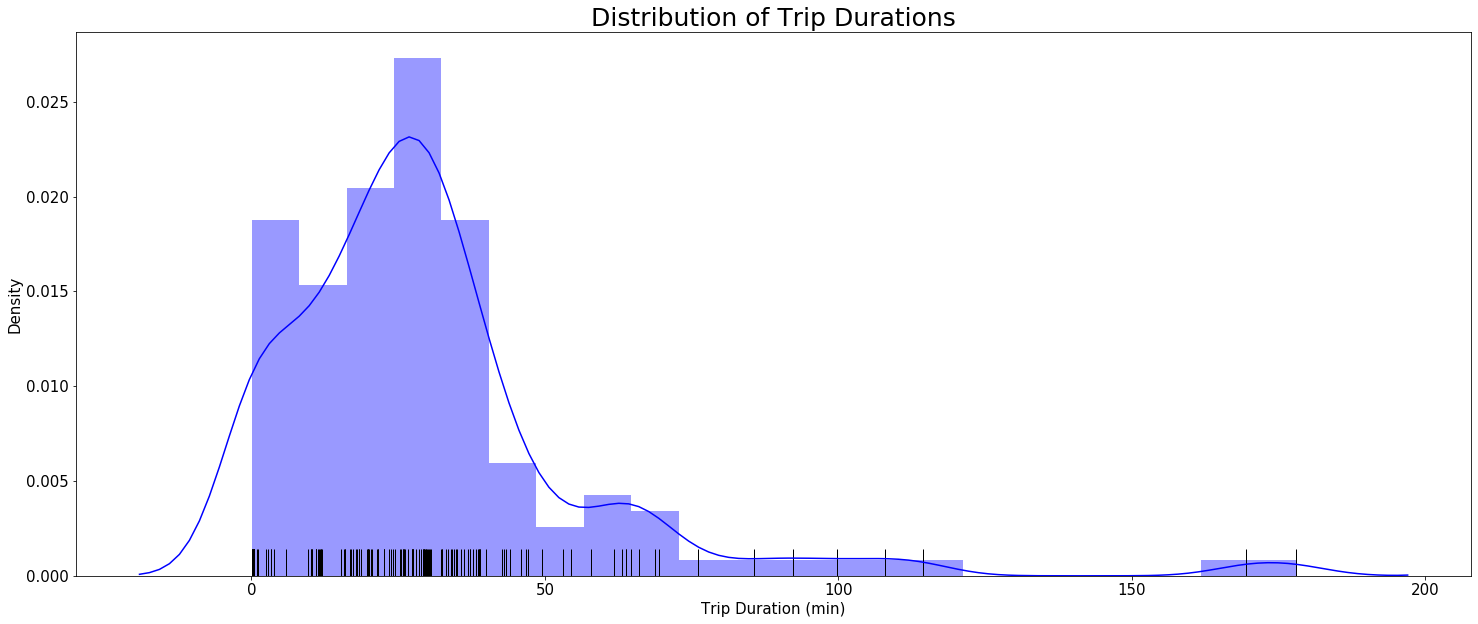

In [421]:
from scipy.stats import describe
print(describe(pivotted.groupby('trip')['epoch'].agg(lambda x: x.max() - x.min())/60))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(pivotted.groupby('trip')['epoch'].agg(lambda x: x.max() - x.min())/60, color='Blue', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Trip Durations', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Trip Duration (min)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)



DescribeResult(nobs=144, minmax=(31.883333333333333, 19090.616666666665), mean=824.7140046296296, variance=4490745.76835922, skewness=7.091118076592457, kurtosis=53.77769095504754)


Text(0, 0.5, 'Density')

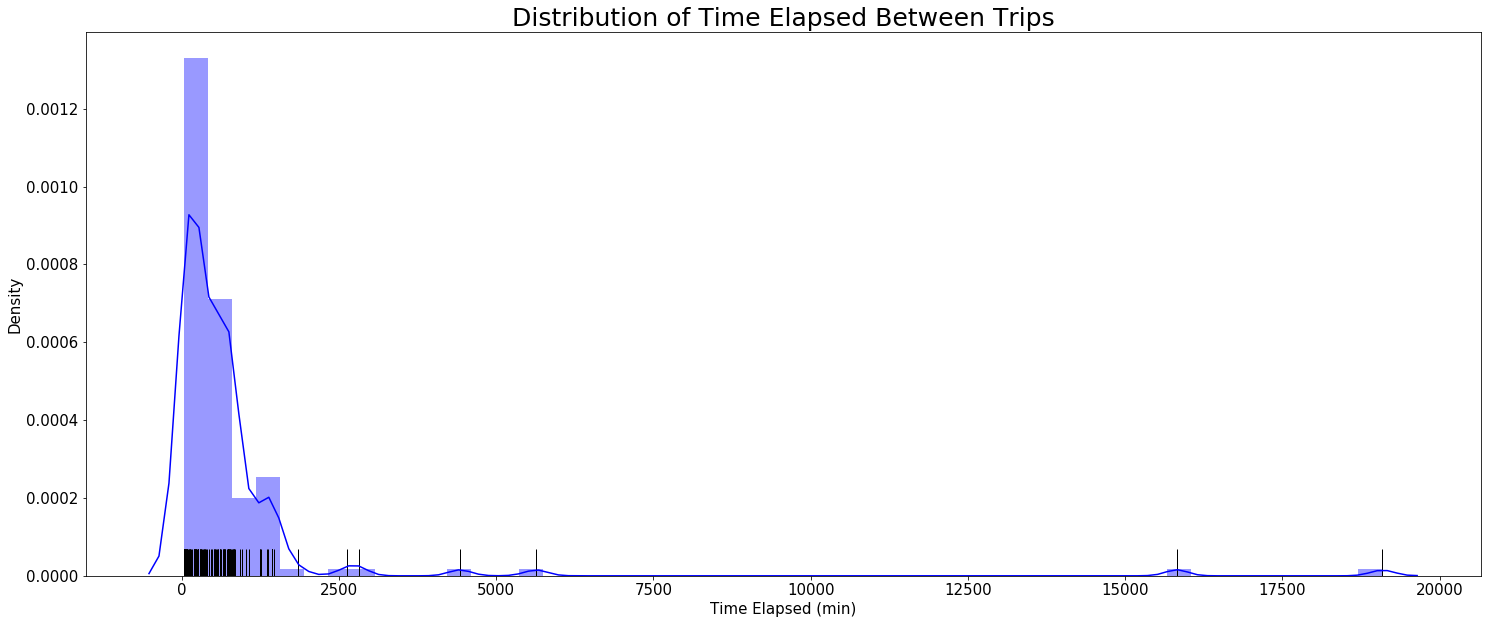

In [422]:
print(describe(pivotted['epoch_diff'][pivotted['epoch_diff'] > 1800]/60))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(pivotted['epoch_diff'][pivotted['epoch_diff'] > 1800]/60, color='Blue', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Time Elapsed Between Trips', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Time Elapsed (min)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)


Transition Between "Outlier" Trips:

In [423]:
trips_large_time_elap = pivotted[pivotted['epoch_diff'] > 1800].sort_values('epoch_diff', ascending=False).head()
ind_to_add = []
for i in trips_large_time_elap.index:
    ind_to_add += [i-1, i]
pivotted.iloc[ind_to_add]

cvdcus_timestamp_s_3         epoch  epoch_diff  trip  BrkTot_Tq_Actl  \
18738   2019-05-05 19:16:38  1.557084e+09         1.0    14             NaN   
18739   2019-05-19 01:27:15  1.558229e+09   1145437.0    15             NaN   
145994  2019-07-06 02:46:29  1.562381e+09         1.0   122             NaN   
145995  2019-07-17 02:24:36  1.563330e+09    949087.0   123             0.0   
153242  2019-07-18 15:49:06  1.563465e+09         1.0   129             NaN   
153243  2019-07-22 13:39:33  1.563803e+09    337827.0   130             0.0   
22431   2019-05-20 14:13:05  1.558362e+09         1.0    20             NaN   
22432   2019-05-23 16:00:15  1.558627e+09    265630.0    21             0.0   
115683  2019-06-25 02:09:33  1.561429e+09         1.0   101             0.0   
115684  2019-06-27 01:05:57  1.561598e+09    168984.0   102             NaN   

       HvacBlwrFront_D_Stat  Veh_V_ActlEng GearLvrPos_D_Actl  \
18738                   NaN            NaN               NaN   
18739                   NaN            NaN             Drive   
145994                  NaN            NaN               NaN   
145995                  NaN       0.000000              Park   
153242                  NaN            NaN             Drive   
153243                  NaN            NaN               NaN   
22431                   NaN            NaN              Park   
22432                   NaN      65.973333             Drive   
115683                  NaN            NaN               NaN   
115684                  NaN       0.000000             Drive   

        ApedPos_Pc_ActlArb  EngAout_N_Actl  ...  AirCondFluidHi_P_Actl  \
18738                  NaN             NaN  ...                    NaN   
18739             7.100000     1164.000000  ...                    NaN   
145994                 NaN             NaN  ...                    NaN   
145995            0.000000      607.000000  ...                    NaN   
153242            5.300000     1276.000000  ...                    NaN   
153243                 NaN             NaN  ...                    NaN   
22431             0.000000      972.000000  ...                    NaN   
22432            18.645455     1890.545455  ...                    NaN   
115683                 NaN             NaN  ...                    NaN   
115684            0.000000      598.000000  ...                    NaN   

        CoolantFanStepAct AirAmb_Te_ActlFilt  Outside_Air_Temp_Stat  \
18738                 NaN                NaN                   10.0   
18739                 NaN              31.00                   33.0   
145994                NaN                NaN                    NaN   
145995                NaN              36.75                    NaN   
153242                NaN                NaN                    NaN   
153243                NaN                NaN                   10.0   
22431                 NaN              21.00                    NaN   
22432                 NaN              24.50                    NaN   
115683                NaN                NaN                    NaN   
115684                NaN                NaN                    NaN   

        OdometerMasterValue Ignition_Status  VehLong2_A_Actl  \
18738                2824.0             Off              NaN   
18739                3806.0             NaN        -0.160000   
145994                  NaN             NaN              NaN   
145995                  NaN             NaN         0.093333   
153242                  NaN             NaN              NaN   
153243               6328.0             Off              NaN   
22431                   NaN             NaN              NaN   
22432                   NaN             NaN         0.614000   
115683                  NaN             NaN              NaN   
115684                  NaN             NaN        -0.080000   

        RearPassWindowPos  DriverWindowPosition PassWindowPosition  
18738                 NaN                   NaN              

It seems that some trips have long intervals where no signals are being transferred. One possible explanation is that when we originally pulled data from BDD, we only selected our signals of interest. By omitting other signals, we are losing data from signals that are being transmitted during these large intervals. Another explanation is that the driver may have been on vacation or may have driven another during these intervals.

Let's narrow our focus and filter out trips with either of the following conditions:
1. trip duration < 60 seconds
2. distance traveled between start and end of trip <= 0 km
3. trip duration > 12 hours (43200 seconds)

In [437]:
trips_to_filter_out = pivotted.groupby('trip')['epoch', 'OdometerMasterValue']\
.agg({'epoch': lambda x: x.max() - x.min(), 'OdometerMasterValue': lambda x: x.max() - x.min()})
trips_to_filter_out = trips_to_filter_out[(trips_to_filter_out['epoch'] < 60) | (trips_to_filter_out['epoch'] > 43200) | (trips_to_filter_out['OdometerMasterValue'] <= 0)].sort_values('epoch')
trips_to_filter_out

C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


epoch  OdometerMasterValue
trip                             
67       3.0                  0.0
32       6.0                  0.0
28       9.0                  0.0
29      10.0                  0.0
37      14.0                  0.0
39      17.0                  0.0
36      22.0                  0.0
34      22.0                  0.0
38      23.0                  0.0
31      24.0                  0.0
30      24.0                  0.0
40      26.0                  0.0
33      26.0                  0.0
35      26.0                  0.0
140     61.0                  0.0
26      68.0                  0.0
139    149.0                  0.0
100    174.0                  0.0
71     196.0                  0.0
123    200.0                  0.0
11     234.0                  0.0
20     357.0                  0.0
69     605.0                  0.0
131    607.0                  0.0
51     618.0                  0.0
98     663.0                  0.0
107    664.0                  0.0
108    664.0                  0.0
19     681.0                  0.0
112    688.0                  0.0
132    698.0                  0.0
93     708.0                  0.0
68     713.0                  0.0
42     718.0                  0.0
18     951.0                  0.0
25    1407.0                  0.0
128   1781.0                  0.0
70    2567.0                  0.0
50    2579.0                  0.0
120   2969.0                  0.0
104   3965.0                  0.0

Some trips, like #120 and #104, have long durations with no odometer change. **Let's revise our filteration criteria and keep trips even if the odometer reading does not change.**

Filter out trips based on below criteria:
1. trip duration < 60 seconds
2. trip duration > 12 hours (43200 seconds)

In [438]:
trips_to_filter_out = trips_to_filter_out[~(trips_to_filter_out['epoch'] > 60)].index # keep trips w/ duration > 60 even if odo change is <= 0
pivotted = pivotted[~pivotted['trip'].isin(trips_to_filter_out)].reset_index(drop=True) # filter out
pivotted['epoch_diff'] = pivotted['epoch'].diff() # recalc epoch diff since some trips now 
pivotted['trip'] = pivotted['trip'].replace({trip: i + 1 for i, trip in enumerate(pivotted['trip'].unique())}) # reset trip flags

Our pivot table contains many missing values. Let's see if filling them in with the closest previous value is appropriate. 

In [290]:
for trip in pivotted['trip'].unique():
    print('trip #: {}; # records where > 5 sec elapsed: {}'.format(trip, str(pivotted[(pivotted['trip'] == trip) & (pivotted['epoch_diff'] > 5)].shape[0])))

trip #: 1; # records where > 5 sec elapsed: 2
trip #: 2; # records where > 5 sec elapsed: 2
trip #: 3; # records where > 5 sec elapsed: 2
trip #: 4; # records where > 5 sec elapsed: 4
trip #: 5; # records where > 5 sec elapsed: 2
trip #: 6; # records where > 5 sec elapsed: 4
trip #: 7; # records where > 5 sec elapsed: 2
trip #: 8; # records where > 5 sec elapsed: 6
trip #: 9; # records where > 5 sec elapsed: 2
trip #: 10; # records where > 5 sec elapsed: 2
trip #: 11; # records where > 5 sec elapsed: 1
trip #: 12; # records where > 5 sec elapsed: 4
trip #: 13; # records where > 5 sec elapsed: 5
trip #: 14; # records where > 5 sec elapsed: 1
trip #: 15; # records where > 5 sec elapsed: 2
trip #: 16; # records where > 5 sec elapsed: 2
trip #: 17; # records where > 5 sec elapsed: 5
trip #: 18; # records where > 5 sec elapsed: 3
trip #: 19; # records where > 5 sec elapsed: 2
trip #: 20; # records where > 5 sec elapsed: 1
trip #: 21; # records where > 5 sec elapsed: 3
trip #: 22; # records 

Since many trips contain intervals > 5 seconds where no data is recorded, it may not be appropriate to fill missing values with previous value. Other options include mean, exponential distribution, and KNN. For now, we will leave missing values as is, and we will deal with them later.

<a id='objectives'></a>
### Objective Statement

To proceed, we will seek to

1. Analyze the gap between actual and requested temp.
2. Identify the duration that the internal temp. of the compressor is below 0°C.
2. Determine the frequency that the internal temp. measures below 0°C.
3. Explore causes for the gap in actual and requested temp. and why the internal temp. measures below 0°C.

<a id='gap_analysis'></a>
**1) Gap Between Actual and Requested Temp.**

DescribeResult(nobs=129007, minmax=(-8.0, 39.5), mean=1.895353500804279, variance=24.333396116456594, skewness=2.2987392839321052, kurtosis=6.91678448150105)


Text(0, 0.5, 'Density')

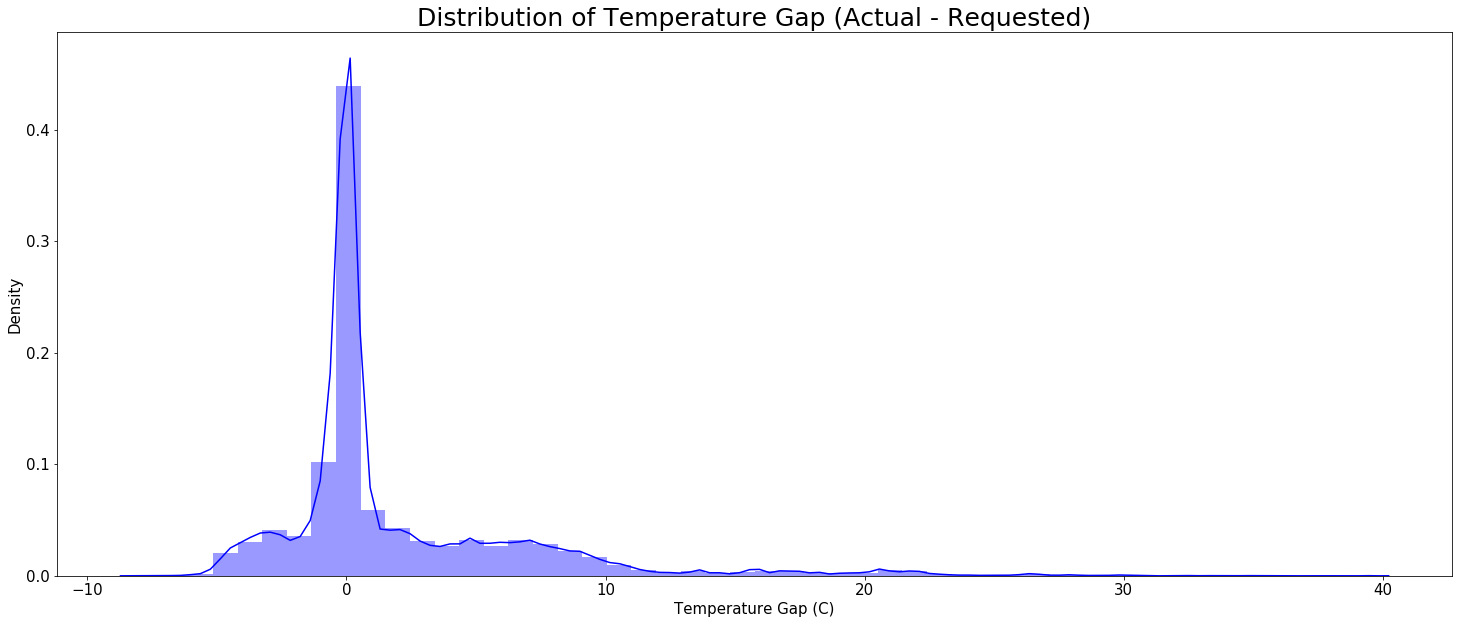

In [439]:
pivotted['temp_gap'] = pivotted['HvacEvap_Te_Actl'] - pivotted['HvacEvap_Te_Rq']
print(describe(pivotted['temp_gap'].dropna()))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(pivotted['temp_gap'], color='Blue')
plt.title('Distribution of Temperature Gap (Actual - Requested)', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Temperature Gap (C)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


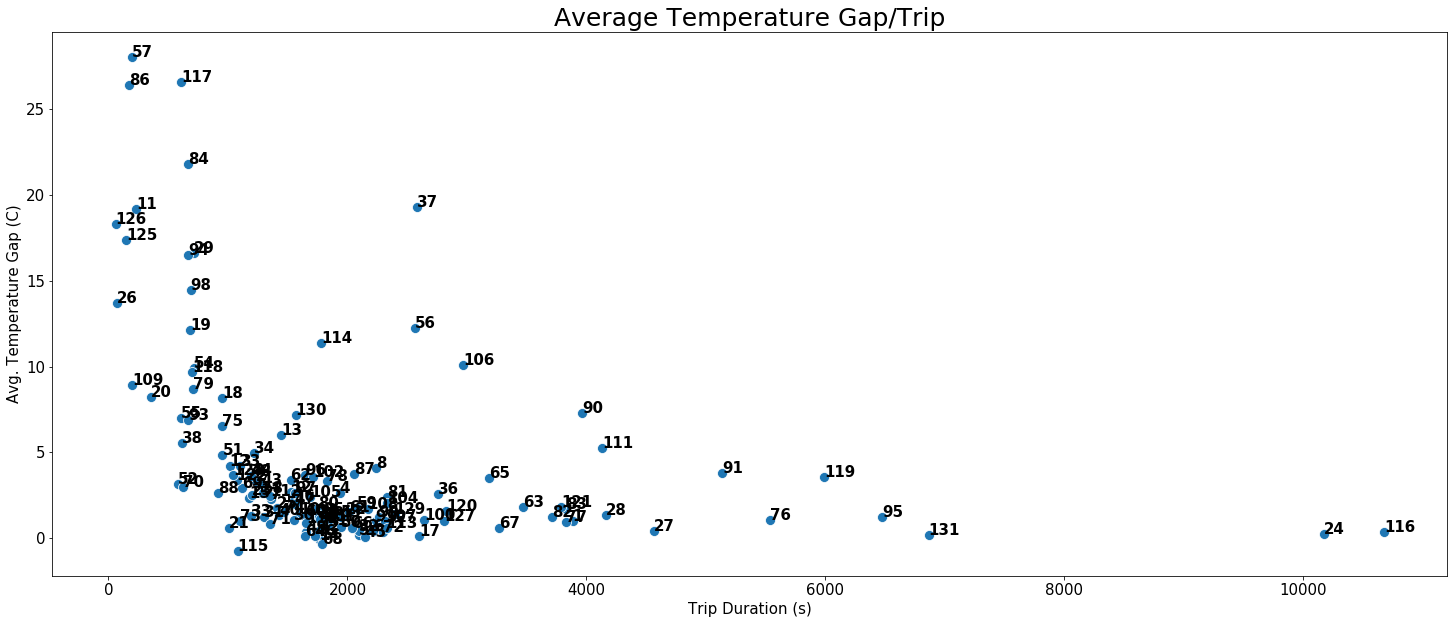

In [292]:
fig, ax = plt.subplots(figsize=(25, 10))
epoch_vs_temp_gap = pivotted.groupby('trip')['epoch', 'temp_gap'].agg({'epoch':lambda x: x.max() - x.min(), 'temp_gap':'mean'})
sns.scatterplot(x='epoch', y='temp_gap', data=epoch_vs_temp_gap, s=100)
plt.title('Average Temperature Gap/Trip', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Trip Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Avg. Temperature Gap (C)', fontsize=15)
for x, y, trip in zip(epoch_vs_temp_gap['epoch'], epoch_vs_temp_gap['temp_gap'], epoch_vs_temp_gap.index):
    plt.text(x, y, str(int(trip)), color="black", fontsize=15, weight='bold')

Let's take a closer look at 
1. trips with large gaps: 57, 117
2. trips with long durations: 24, 116
3. trips with large gaps & long durations: 37, 106

In [426]:
# function to plot gap between actual and requested temp.
def plot_gap(df, title, xlab, ylab, s=None):  
    mean = df['temp_gap'].mean()
    std = df['temp_gap'].std()
    fig, ax = plt.subplots(figsize=(25, 10))
    df_for_vis = df[((df['temp_gap'] - mean) / std) > s].reset_index() # only select dt w/ gap > s std
    if s is None:
        df_for_vis = pd.melt(df, id_vars=['epoch'], value_vars=['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], var_name='evap_status', value_name='temp_gap')
    else:
        df_for_vis = pd.melt(df_for_vis, id_vars=[time], value_vars=['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], var_name='evap_status', value_name='temp_gap')
    df_for_vis['time_elap'] = (df_for_vis['epoch'] - df_for_vis['epoch'].min()).astype(int)
    sns.lineplot(x="time_elap", y="temp_gap", hue="evap_status", data=df_for_vis, ax=ax, marker='o', markersize=10)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.legend(prop={'size': 15})

In [294]:
trips_large_gap = [57, 117]
trips_long_dur = [24, 116]
trips_long_gap_dur = [37, 106]

**Large Gap**

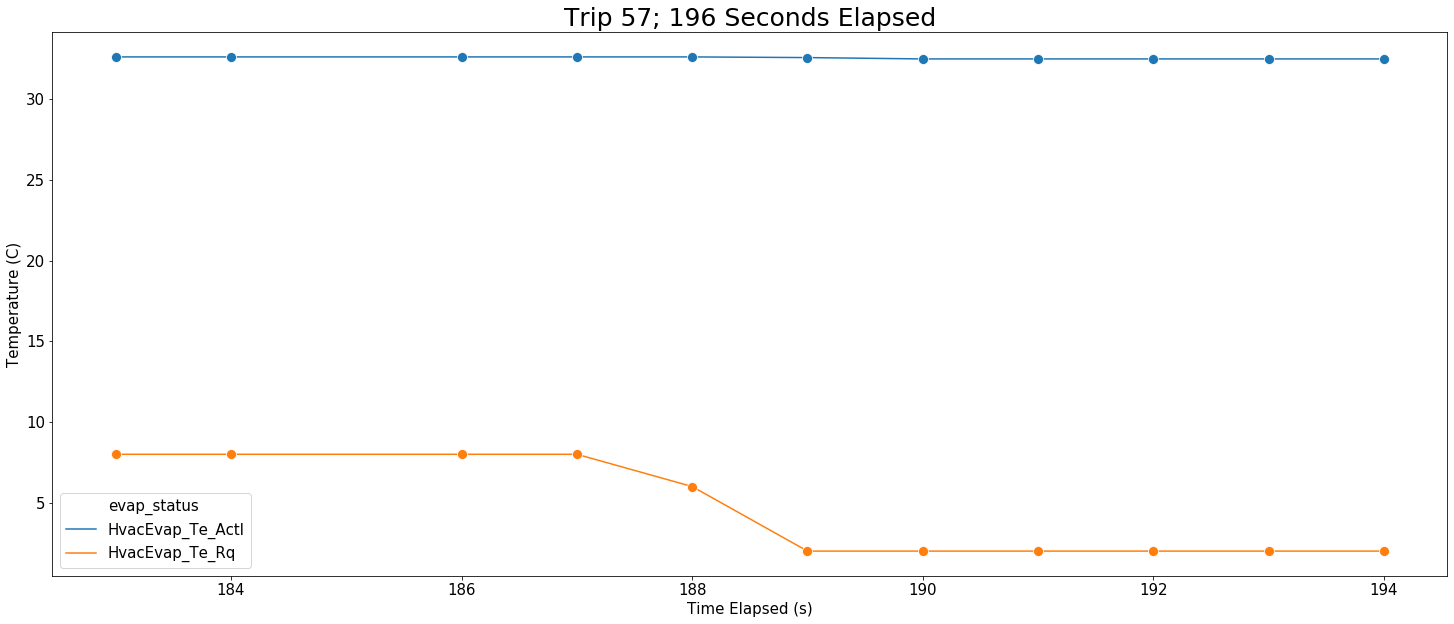

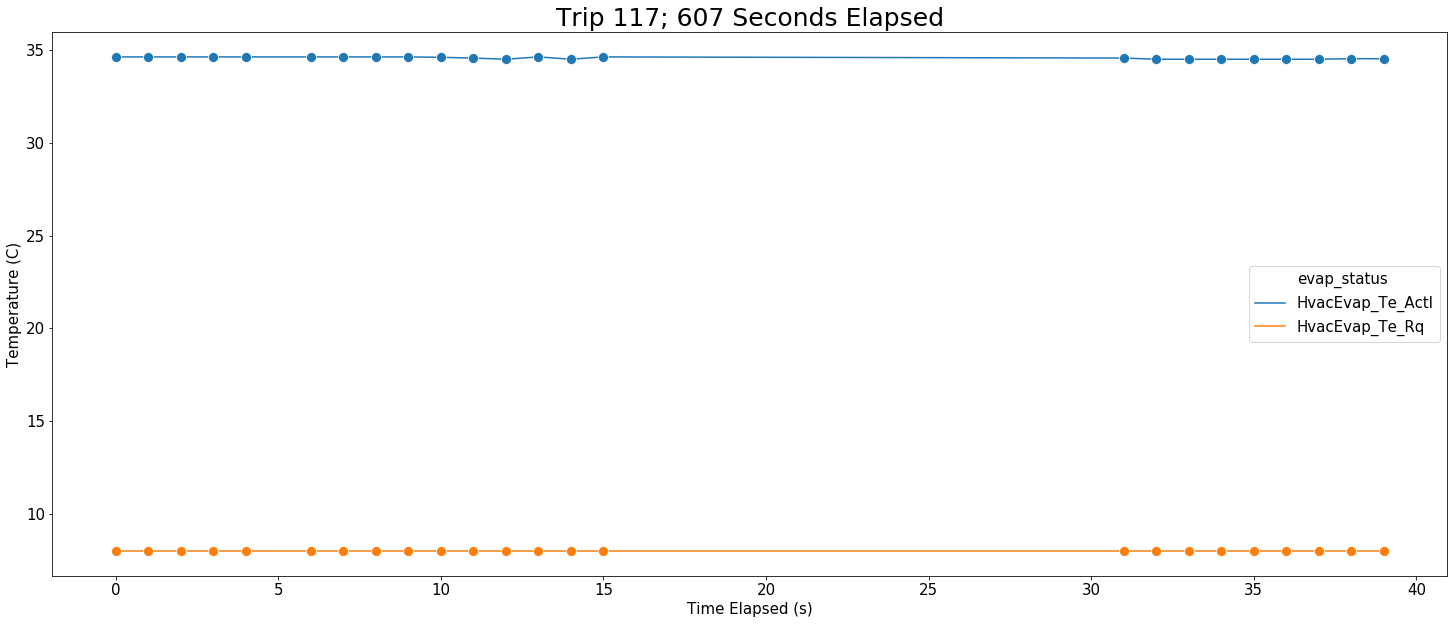

In [295]:
for trip in trips_large_gap:
    data = pivotted[pivotted['trip'] == trip]
    sec_elap = int(data['epoch'].max() - data['epoch'].min())
    plot_gap(pivotted[pivotted['trip'] == trip], f'Trip {trip}; {sec_elap} Seconds Elapsed', 'Time Elapsed (s)', 'Temperature (C)')

**Long Duration**

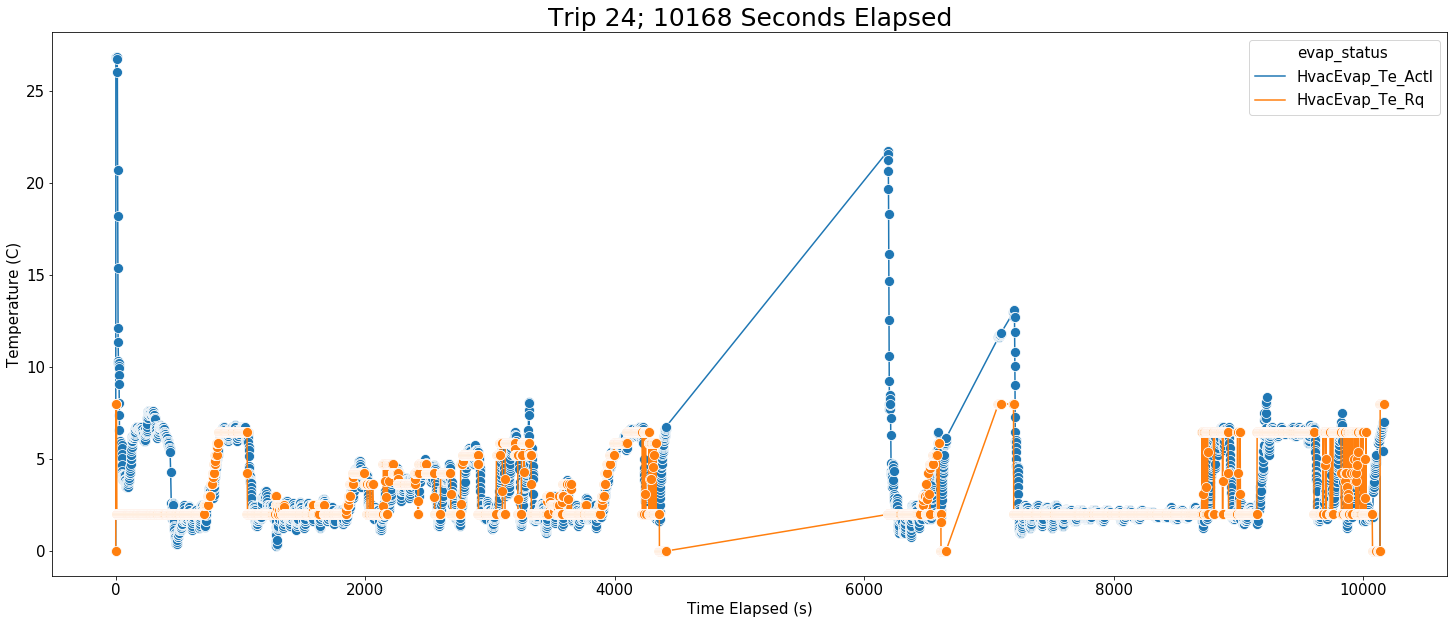

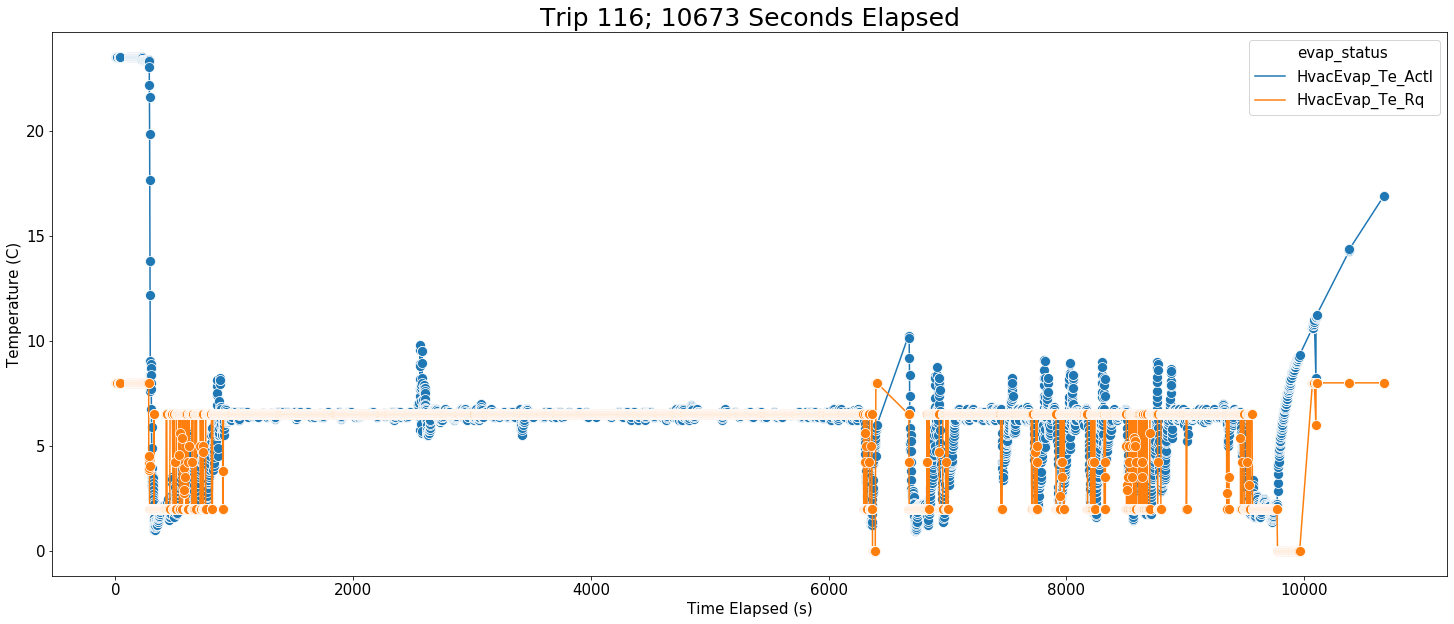

In [296]:
for trip in trips_long_dur:
    data = pivotted[pivotted['trip'] == trip]
    sec_elap = int(data['epoch'].max() - data['epoch'].min())
    plot_gap(pivotted[pivotted['trip'] == trip], f'Trip {trip}; {sec_elap} Seconds Elapsed', 'Time Elapsed (s)', 'Temperature (C)')

**Large Gap & Long Duration**

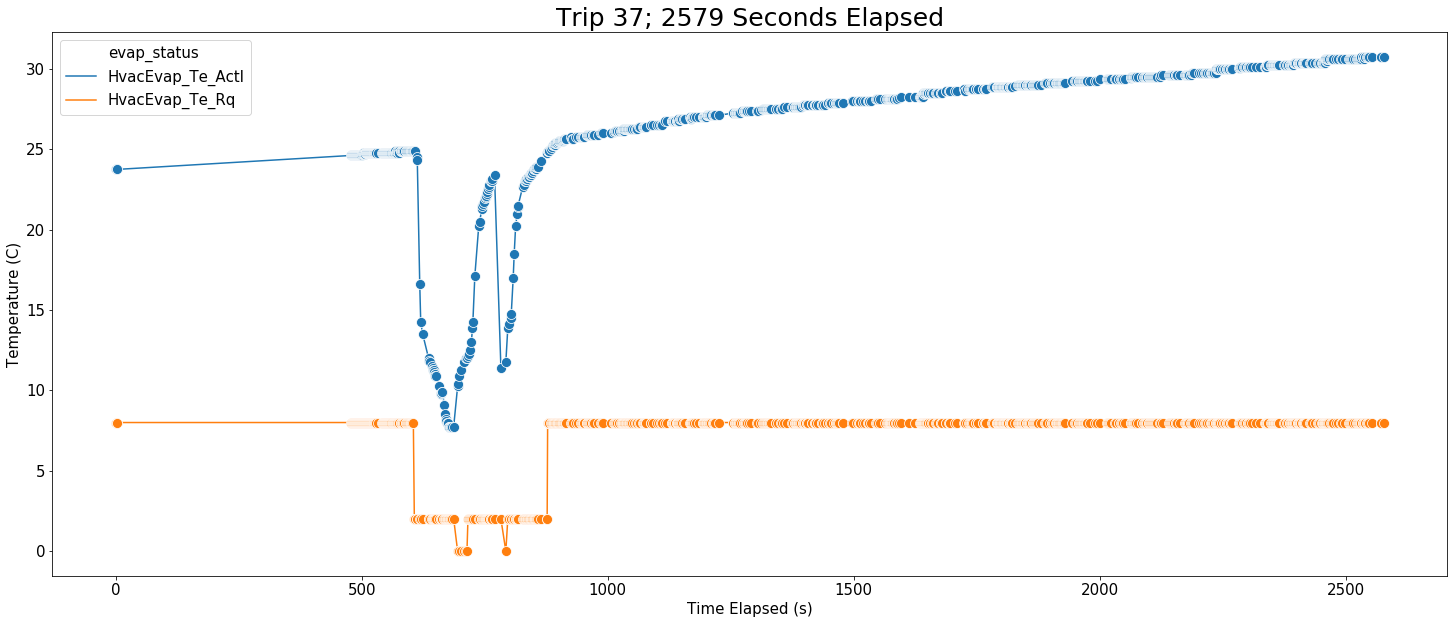

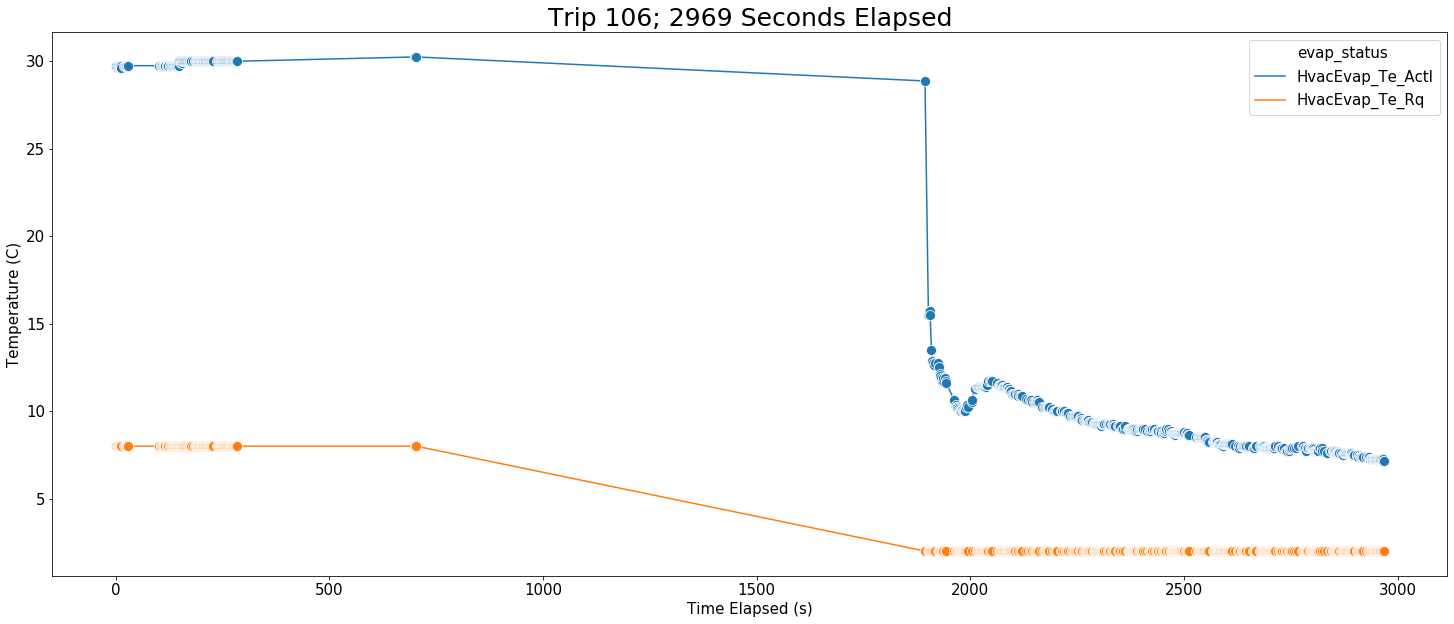

In [297]:
for trip in trips_long_gap_dur:
    data = pivotted[pivotted['trip'] == trip]
    sec_elap = int(data['epoch'].max() - data['epoch'].min())
    plot_gap(pivotted[pivotted['trip'] == trip], f'Trip {trip}; {sec_elap} Seconds Elapsed', 'Time Elapsed (s)', 'Temperature (C)')

We will proceed by further exploring trip 37, as it lasted for ~43 minutes and contains significant data points and a large temperature gap.

**Trip 31:**

**Comparison of Imputation Techniques:**

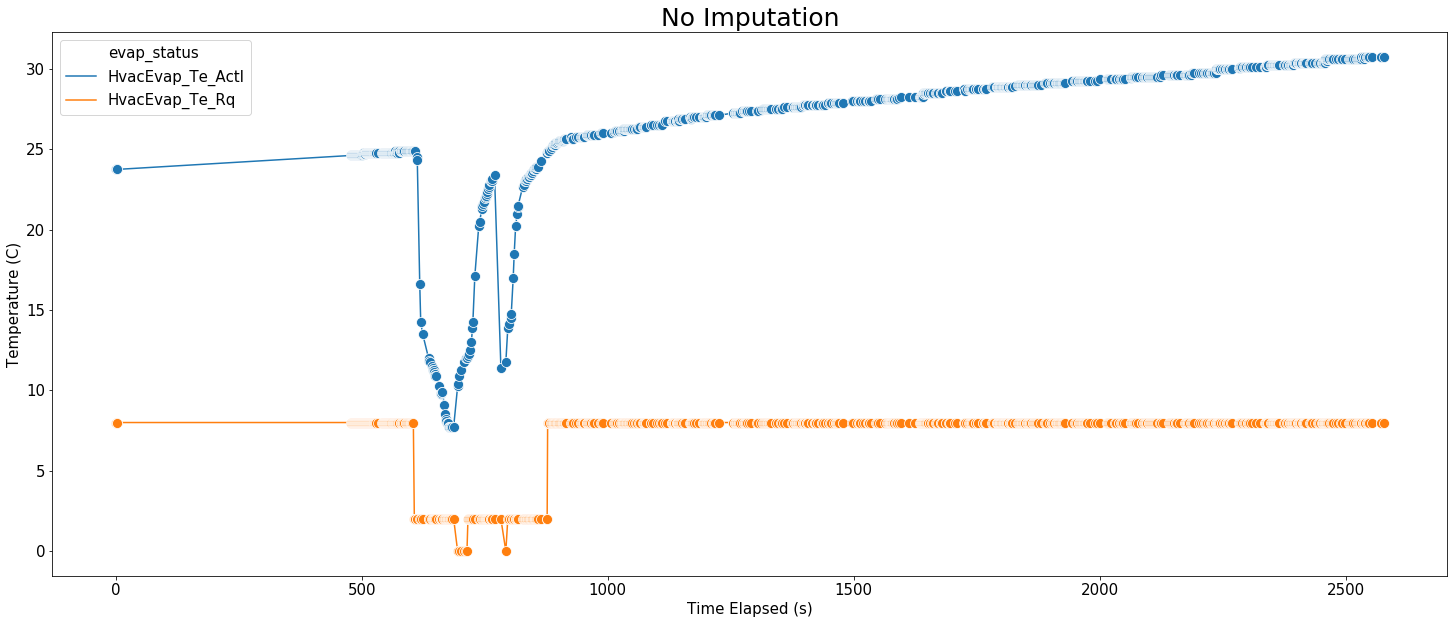

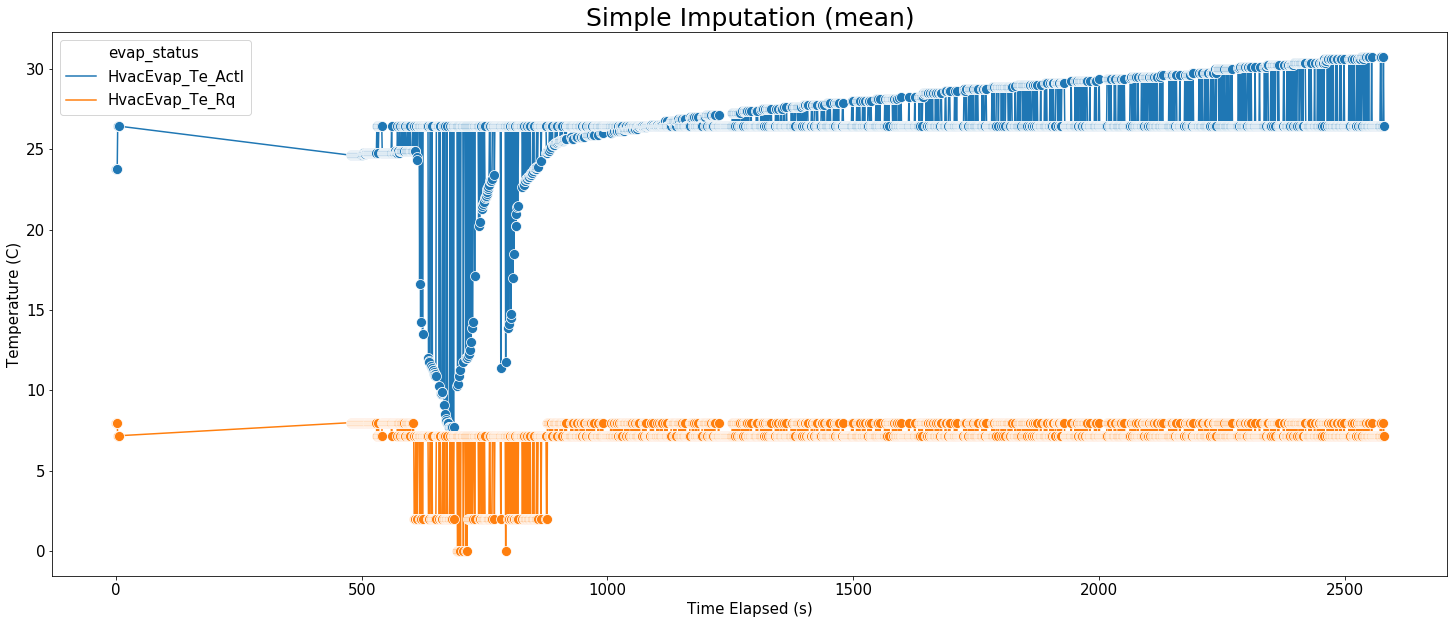

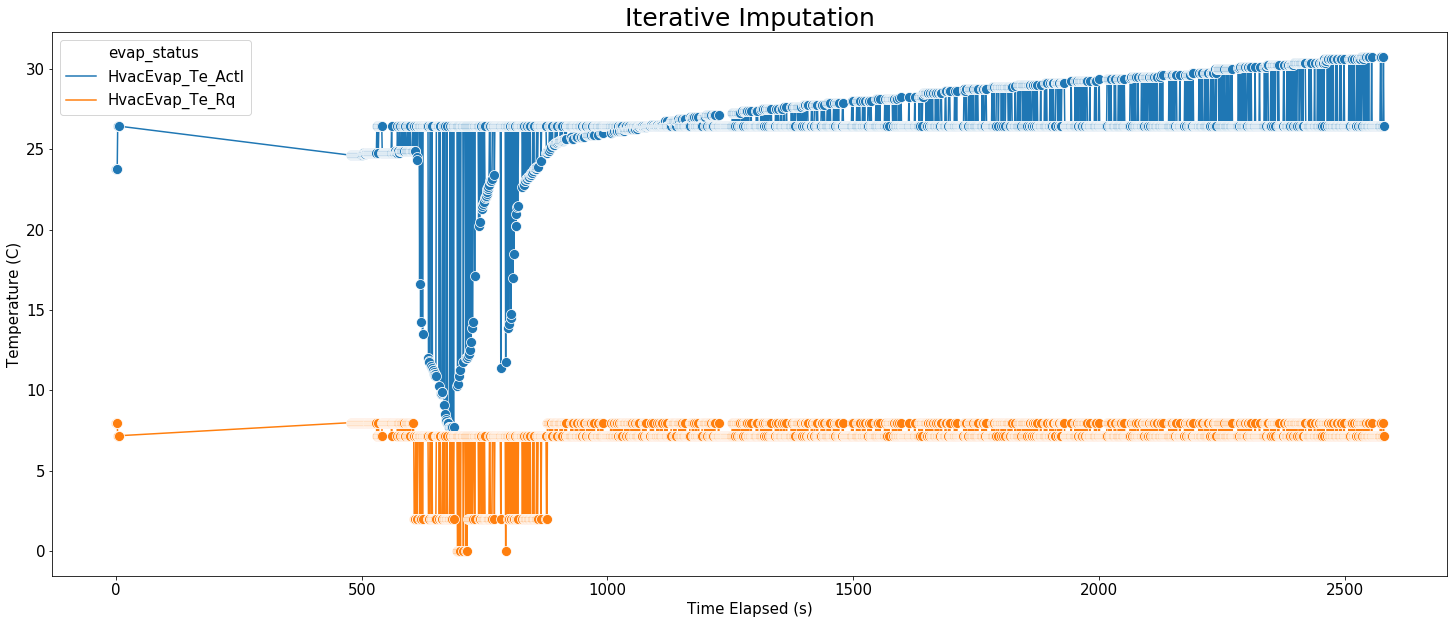

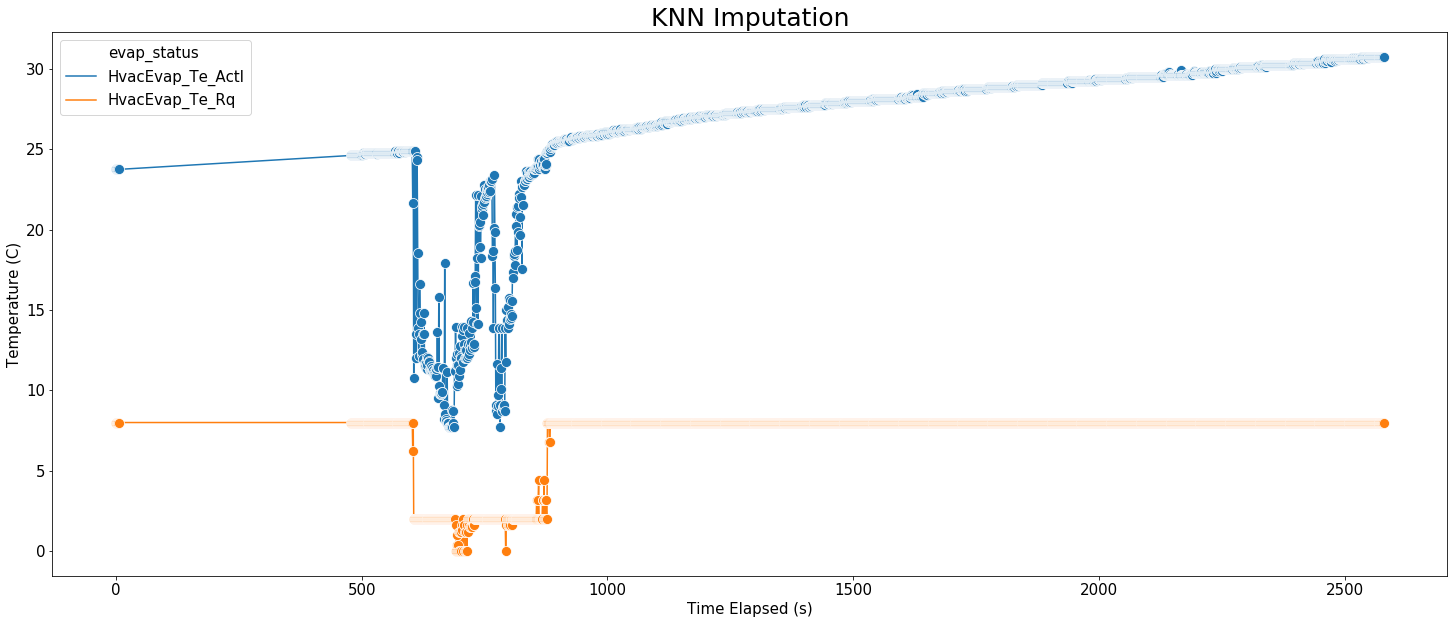

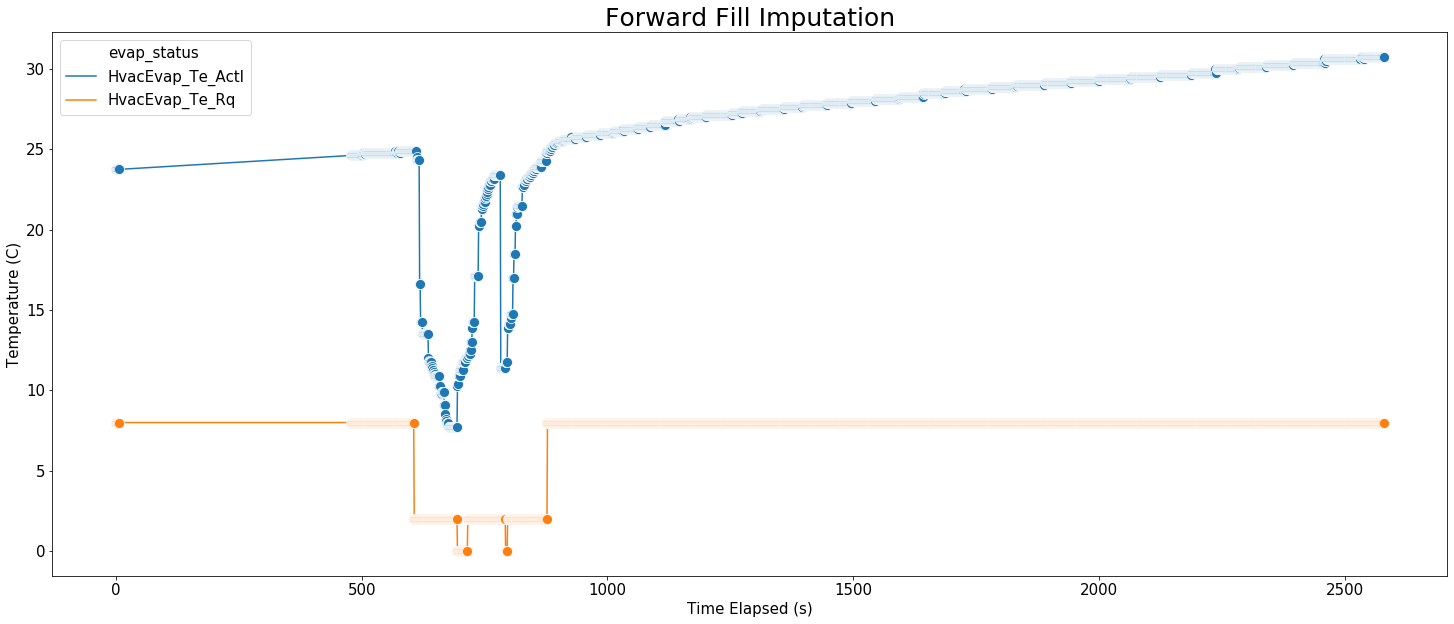

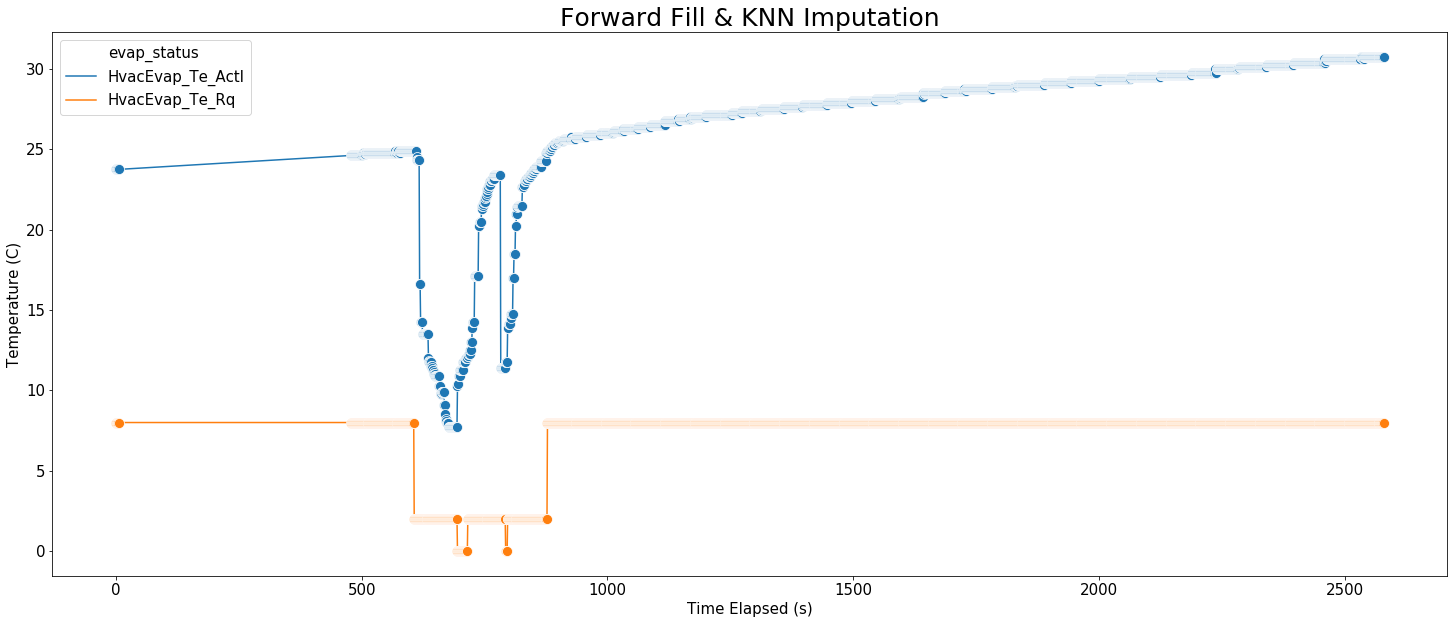

In [298]:
plot_gap(pivotted[pivotted['trip'] == 37], 'No Imputation', 'Time Elapsed (s)', 'Temperature (C)')
# fill nans using simple imputer
from sklearn.impute import SimpleImputer
trip37 = pivotted[pivotted['trip'] == 37]
trip37 = trip37[['epoch'] + list(trip37.columns[4:])]
trip37 = trip37.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
imputer = SimpleImputer()
trip37_one_hot_encoded = pd.get_dummies(trip37)
trip37 = pd.DataFrame(imputer.fit_transform(trip37_one_hot_encoded), index=trip37.index, columns=trip37_one_hot_encoded.columns)
plot_gap(trip37, 'Simple Imputation (mean)', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
trip37 = pivotted[pivotted['trip'] == 37]
trip37 = trip37[['epoch'] + list(trip37.columns[4:])]
trip37 = trip37.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
imputer = IterativeImputer()
trip37_one_hot_encoded = pd.get_dummies(trip37)
trip37 = pd.DataFrame(imputer.fit_transform(trip37_one_hot_encoded), index=trip37.index, columns=trip37_one_hot_encoded.columns)
plot_gap(trip37, 'Iterative Imputation', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using KNN imputer
from sklearn.impute import KNNImputer
trip37 = pivotted[pivotted['trip'] == 37]
trip37 = trip37[['epoch'] + list(trip37.columns[4:])]
trip37 = trip37.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
imputer = KNNImputer(weights='distance')
trip37_one_hot_encoded = pd.get_dummies(trip37)
trip37 = pd.DataFrame(imputer.fit_transform(trip37_one_hot_encoded), index=trip37.index, columns=trip37_one_hot_encoded.columns)
plot_gap(trip37, 'KNN Imputation', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using forward fill
trip37 = pivotted[pivotted['trip'] == 37].fillna(method='ffill')
trip37 = trip37[['epoch'] + list(trip37.columns[4:])]
trip37 = trip37.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
trip37_one_hot_encoded = pd.get_dummies(trip37)
trip37 = pd.DataFrame(imputer.fit_transform(trip37_one_hot_encoded), index=trip37.index, columns=trip37_one_hot_encoded.columns)
plot_gap(trip37, 'Forward Fill Imputation', 'Time Elapsed (s)', 'Temperature (C)')

# fill nans using combination of forward fill (features w/ >= 50% non-nulls) and KNN (remaining features)
cols_to_ffill = ['BrkTot_Tq_Actl', 'Veh_V_ActlEng', 'GearLvrPos_D_Actl','ApedPos_Pc_ActlArb', 'EngAout_N_Actl', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'HvacAirCond_B_Rq', 'BattULo_U_Actl', 'AirAmb_Te_ActlFilt', 'Outside_Air_Temp_Stat', 'OdometerMasterValue', 'VehLong2_A_Actl', 'temp_gap']
trip37 = pivotted[pivotted['trip'] == 37]
trip37 = trip37[['epoch'] + list(trip37.columns[4:])]
trip37 = trip37.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
trip37[cols_to_ffill] = trip37[cols_to_ffill].fillna(method='ffill')
imputer = KNNImputer(weights='distance')
trip37_one_hot_encoded = pd.get_dummies(trip37)
trip37 = pd.DataFrame(imputer.fit_transform(trip37_one_hot_encoded), index=trip37.index, columns=trip37_one_hot_encoded.columns)
plot_gap(trip37, 'Forward Fill & KNN Imputation', 'Time Elapsed (s)', 'Temperature (C)')

There is added noise with all imputation techniques, but a combination of forward filling features with at least 50% non-null values and using KNN imputation for the remaining features seems the most optimal.

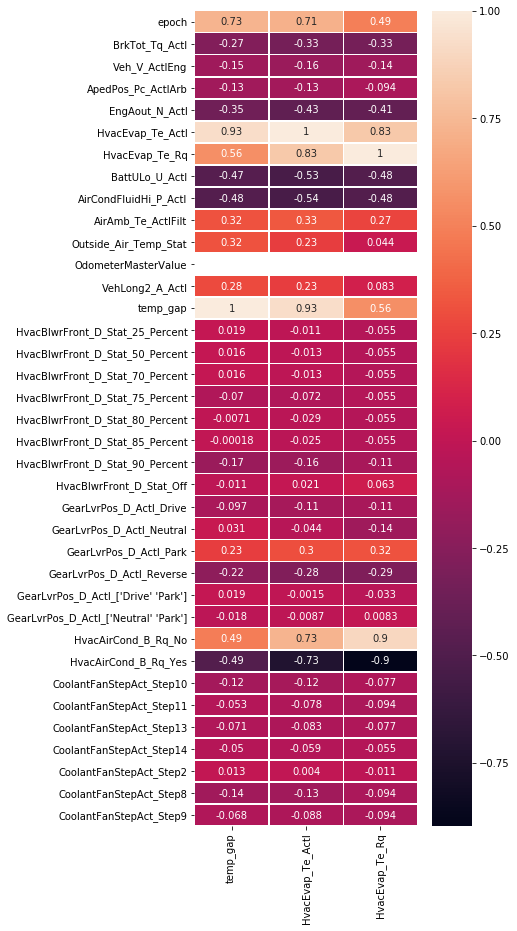

In [299]:
corr_matrix = trip37.corr()
f, ax = plt.subplots(figsize=(5, 15)) 
heatmap = sns.heatmap(corr_matrix.loc[['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], :].transpose(), linewidths=0.5, annot=True)

Noteworthy correlations exist between temperature and the following:
1. EngAout_N_Actl
2. BattULo_U_Actl
3. AirCondFluidHi_P_Actl

We will plot these correlations to see if we can gather any insights.

In [131]:
# function to plot relationship between temp and other var.
def plot_rel(data, feature, title, xlab, ylab):
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.lineplot(x=feature, y="temp", hue="Temperature", data=pd.melt(data.rename(columns={'HvacEvap_Te_Actl':'Actual', 'HvacEvap_Te_Rq':'Requested', 'temp_gap':'Gap'}), id_vars=['epoch', feature], value_vars=['Actual', 'Requested', 'Gap'], var_name='Temperature', value_name='temp'), ax=ax, marker='o', markersize=10)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.legend(prop={'size': 15})

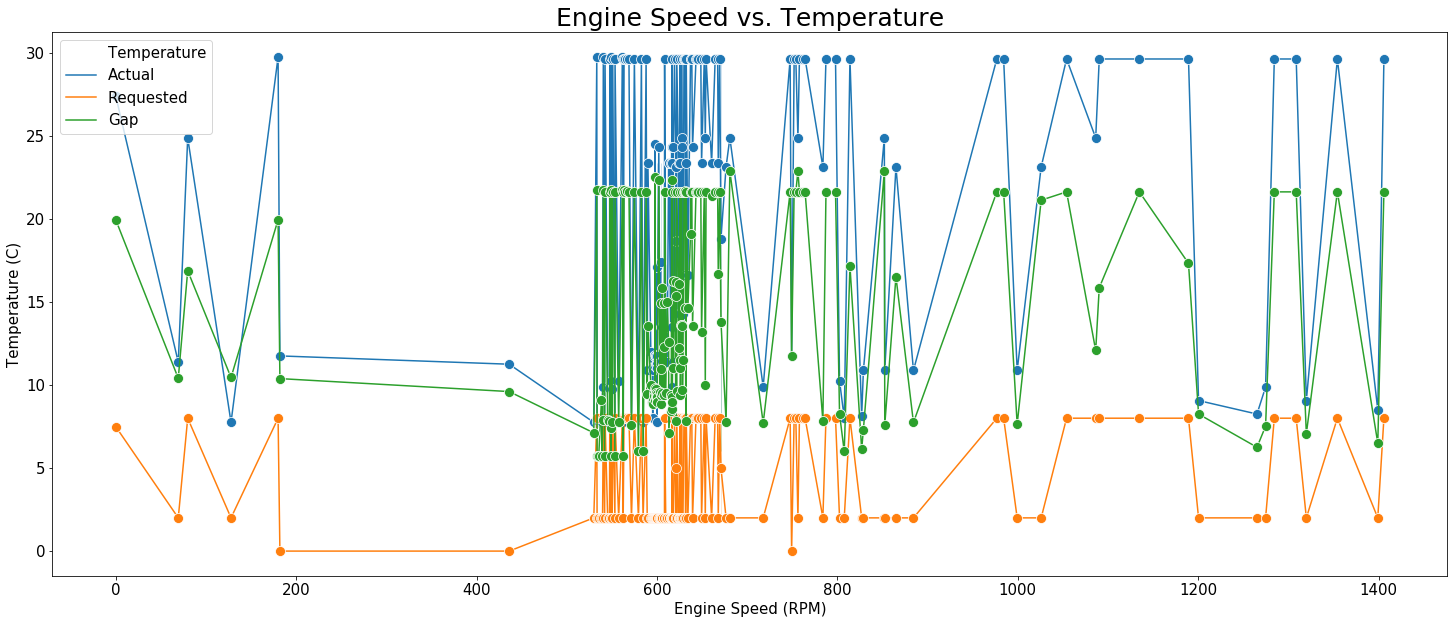

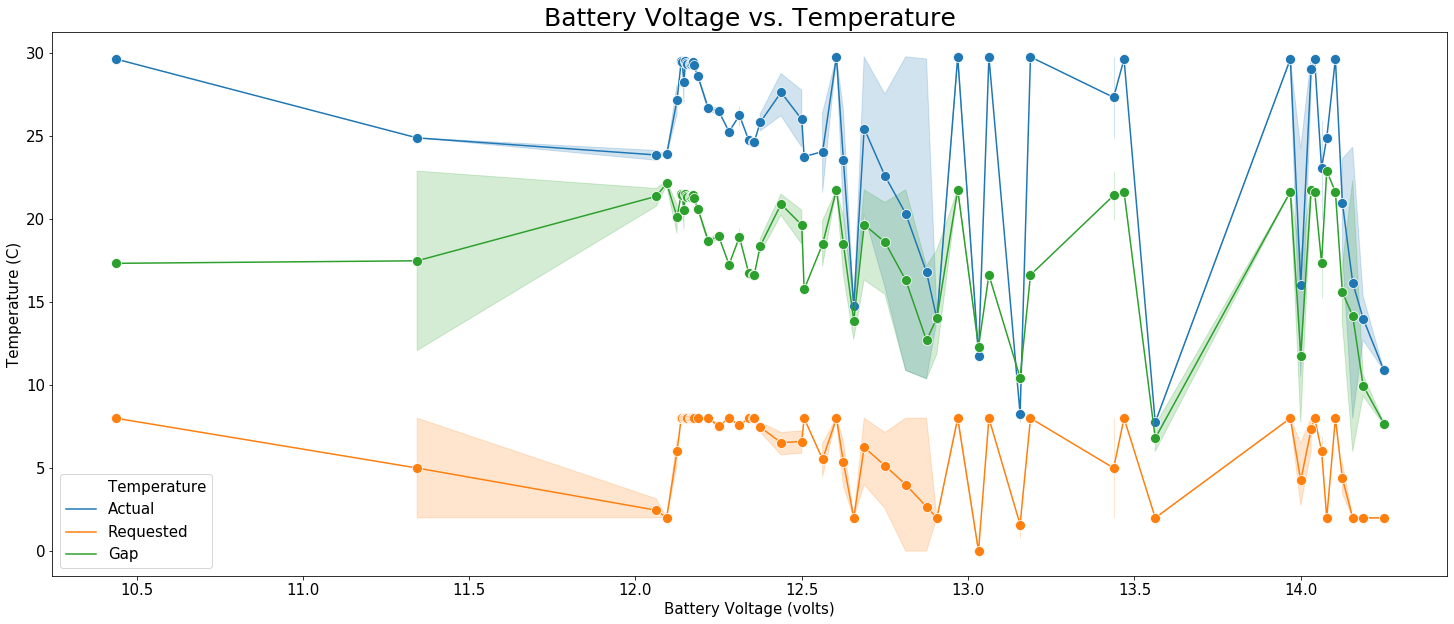

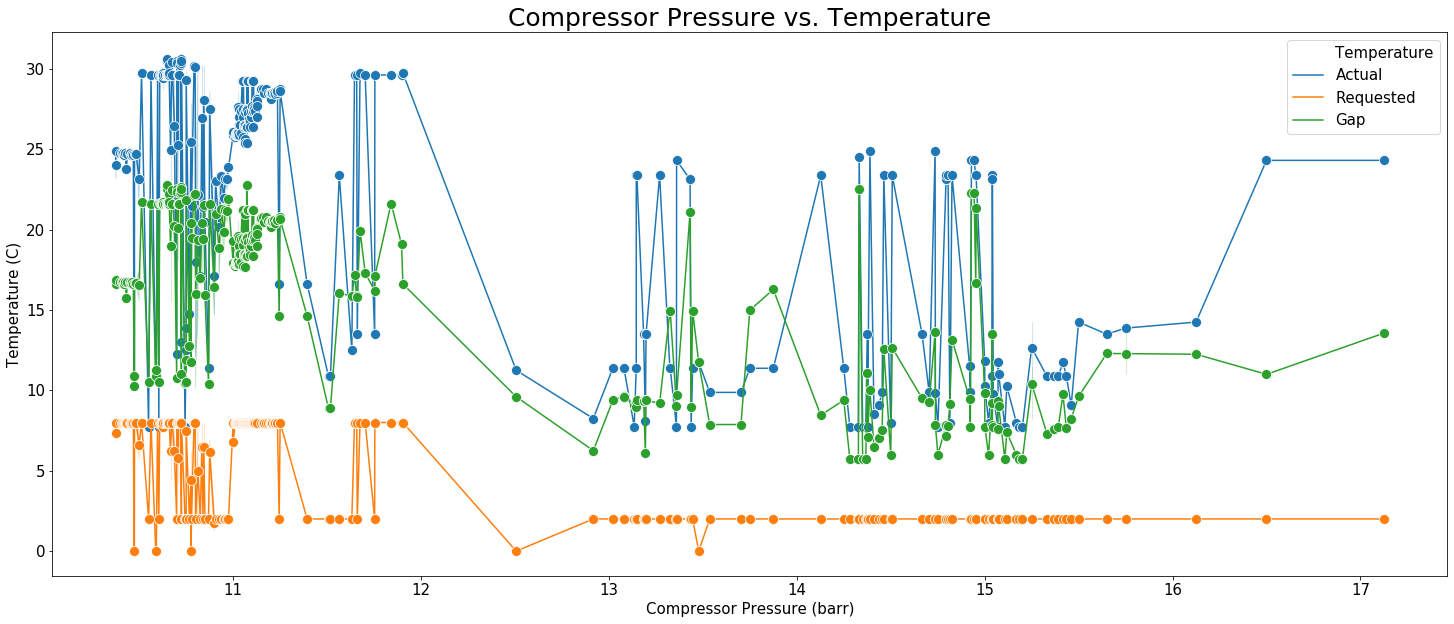

In [122]:
plot_rel(trip37, "EngAout_N_Actl","Engine Speed vs. Temperature" , 'Engine Speed (RPM)', 'Temperature (C)')
plot_rel(trip37, "BattULo_U_Actl","Battery Voltage vs. Temperature" , 'Battery Voltage (volts)', 'Temperature (C)')
plot_rel(trip37, "AirCondFluidHi_P_Actl","Compressor Pressure vs. Temperature" , 'Compressor Pressure (barr)', 'Temperature (C)')


No conclusive insights can be obtained from the above plots. Let's try a different approach and analyze correlations between features at a trip level. We will find the average correlation between temperature and each feature amongst all trips.

In [206]:
# function to get dummies and impute
def make_dummies_and_impute(trip_num):
    trip = pivotted[pivotted['trip'] == trip_num]
    trip = trip[['epoch'] + list(trip.columns[4:])]
    trip = trip.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
    trip[cols_to_ffill] = trip[cols_to_ffill].fillna(method='ffill')
    imputer = KNNImputer(weights='distance')
    trip_one_hot_encoded = pd.get_dummies(trip)
    trip = pd.DataFrame(imputer.fit_transform(trip_one_hot_encoded), index=trip.index, columns=trip_one_hot_encoded.columns)
    return trip_one_hot_encoded
# function to get df with corr matrix for each trip
def get_corr_mat_all_trips():
    trips = pivotted['trip'].unique()
    temp_cols = ['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq']
    trip_data = [make_dummies_and_impute(trip).corr().loc[temp_cols].drop(temp_cols, axis=1) for trip in trips]
    return trip_data

In [201]:
for trip in pivotted['trip'].unique():
    try:
        make_dummies_and_impute(trip)
    except ValueError:
        print(trip)
        print(pivotted[pivotted['trip'] == trip].info())
        print()

# trip = pivotted[pivotted['trip'] == 117]
# trip = trip[['epoch'] + list(trip.columns[4:])]
# trip = trip.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
# trip[cols_to_ffill] = trip[cols_to_ffill].fillna(method='ffill')
# imputer = KNNImputer(weights='distance')
# trip_one_hot_encoded = pd.get_dummies(trip)
# #trip = pd.DataFrame(imputer.fit_transform(trip_one_hot_encoded), index=trip.index, columns=trip_one_hot_encoded.columns)
# trip_one_hot_encoded.info()        

29
<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 41534 to 41731
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cvdcus_timestamp_s_3   198 non-null    datetime64[ns]
 1   epoch                  198 non-null    float64       
 2   epoch_diff             198 non-null    float64       
 3   trip                   198 non-null    int64         
 4   BrkTot_Tq_Actl         194 non-null    float64       
 5   HvacBlwrFront_D_Stat   72 non-null     object        
 6   Veh_V_ActlEng          166 non-null    float64       
 7   GearLvrPos_D_Actl      166 non-null    object        
 8   ApedPos_Pc_ActlArb     166 non-null    float64       
 9   EngAout_N_Actl         166 non-null    float64       
 10  HvacEvap_Te_Actl       175 non-null    float64       
 11  HvacEvap_Te_Rq         175 non-null    float64       
 12  HvacAirCond_B_Rq       175 non-null    object        
 

Above 6 trips (29, 55, 86, 117, 125, 126) have all have at least one feature with no values, making it harder to analyze these trips. We will drop these for now.

In [440]:
trips_to_filter_out = [29, 55, 86, 117, 125, 126]
pivotted = pivotted[~pivotted['trip'].isin(trips_to_filter_out)].reset_index(drop=True) # filter out
pivotted['epoch_diff'] = pivotted['epoch'].diff() # recalc epoch diff since some trips now 
pivotted['trip'] = pivotted['trip'].replace({trip: i + 1 for i, trip in enumerate(pivotted['trip'].unique())}) # reset trip flags

In [441]:
#pivotted.to_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_finaltripflags.csv', index=False)

In [301]:
corr_data_all_trips = get_corr_mat_all_trips()
corr_data_agg = pd.concat(corr_data_all_trips).reset_index().groupby('index').mean().reset_index()

In [445]:
#corr_data_agg.to_csv('corr_data_agg.csv', index=False)

In [226]:
def make_barplot_agg_corr(x, y, title, xlab, ylab):
    fig, ax = plt.subplots(figsize=(15, 40))
    sns.barplot(x, y)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.legend(prop={'size': 15})

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


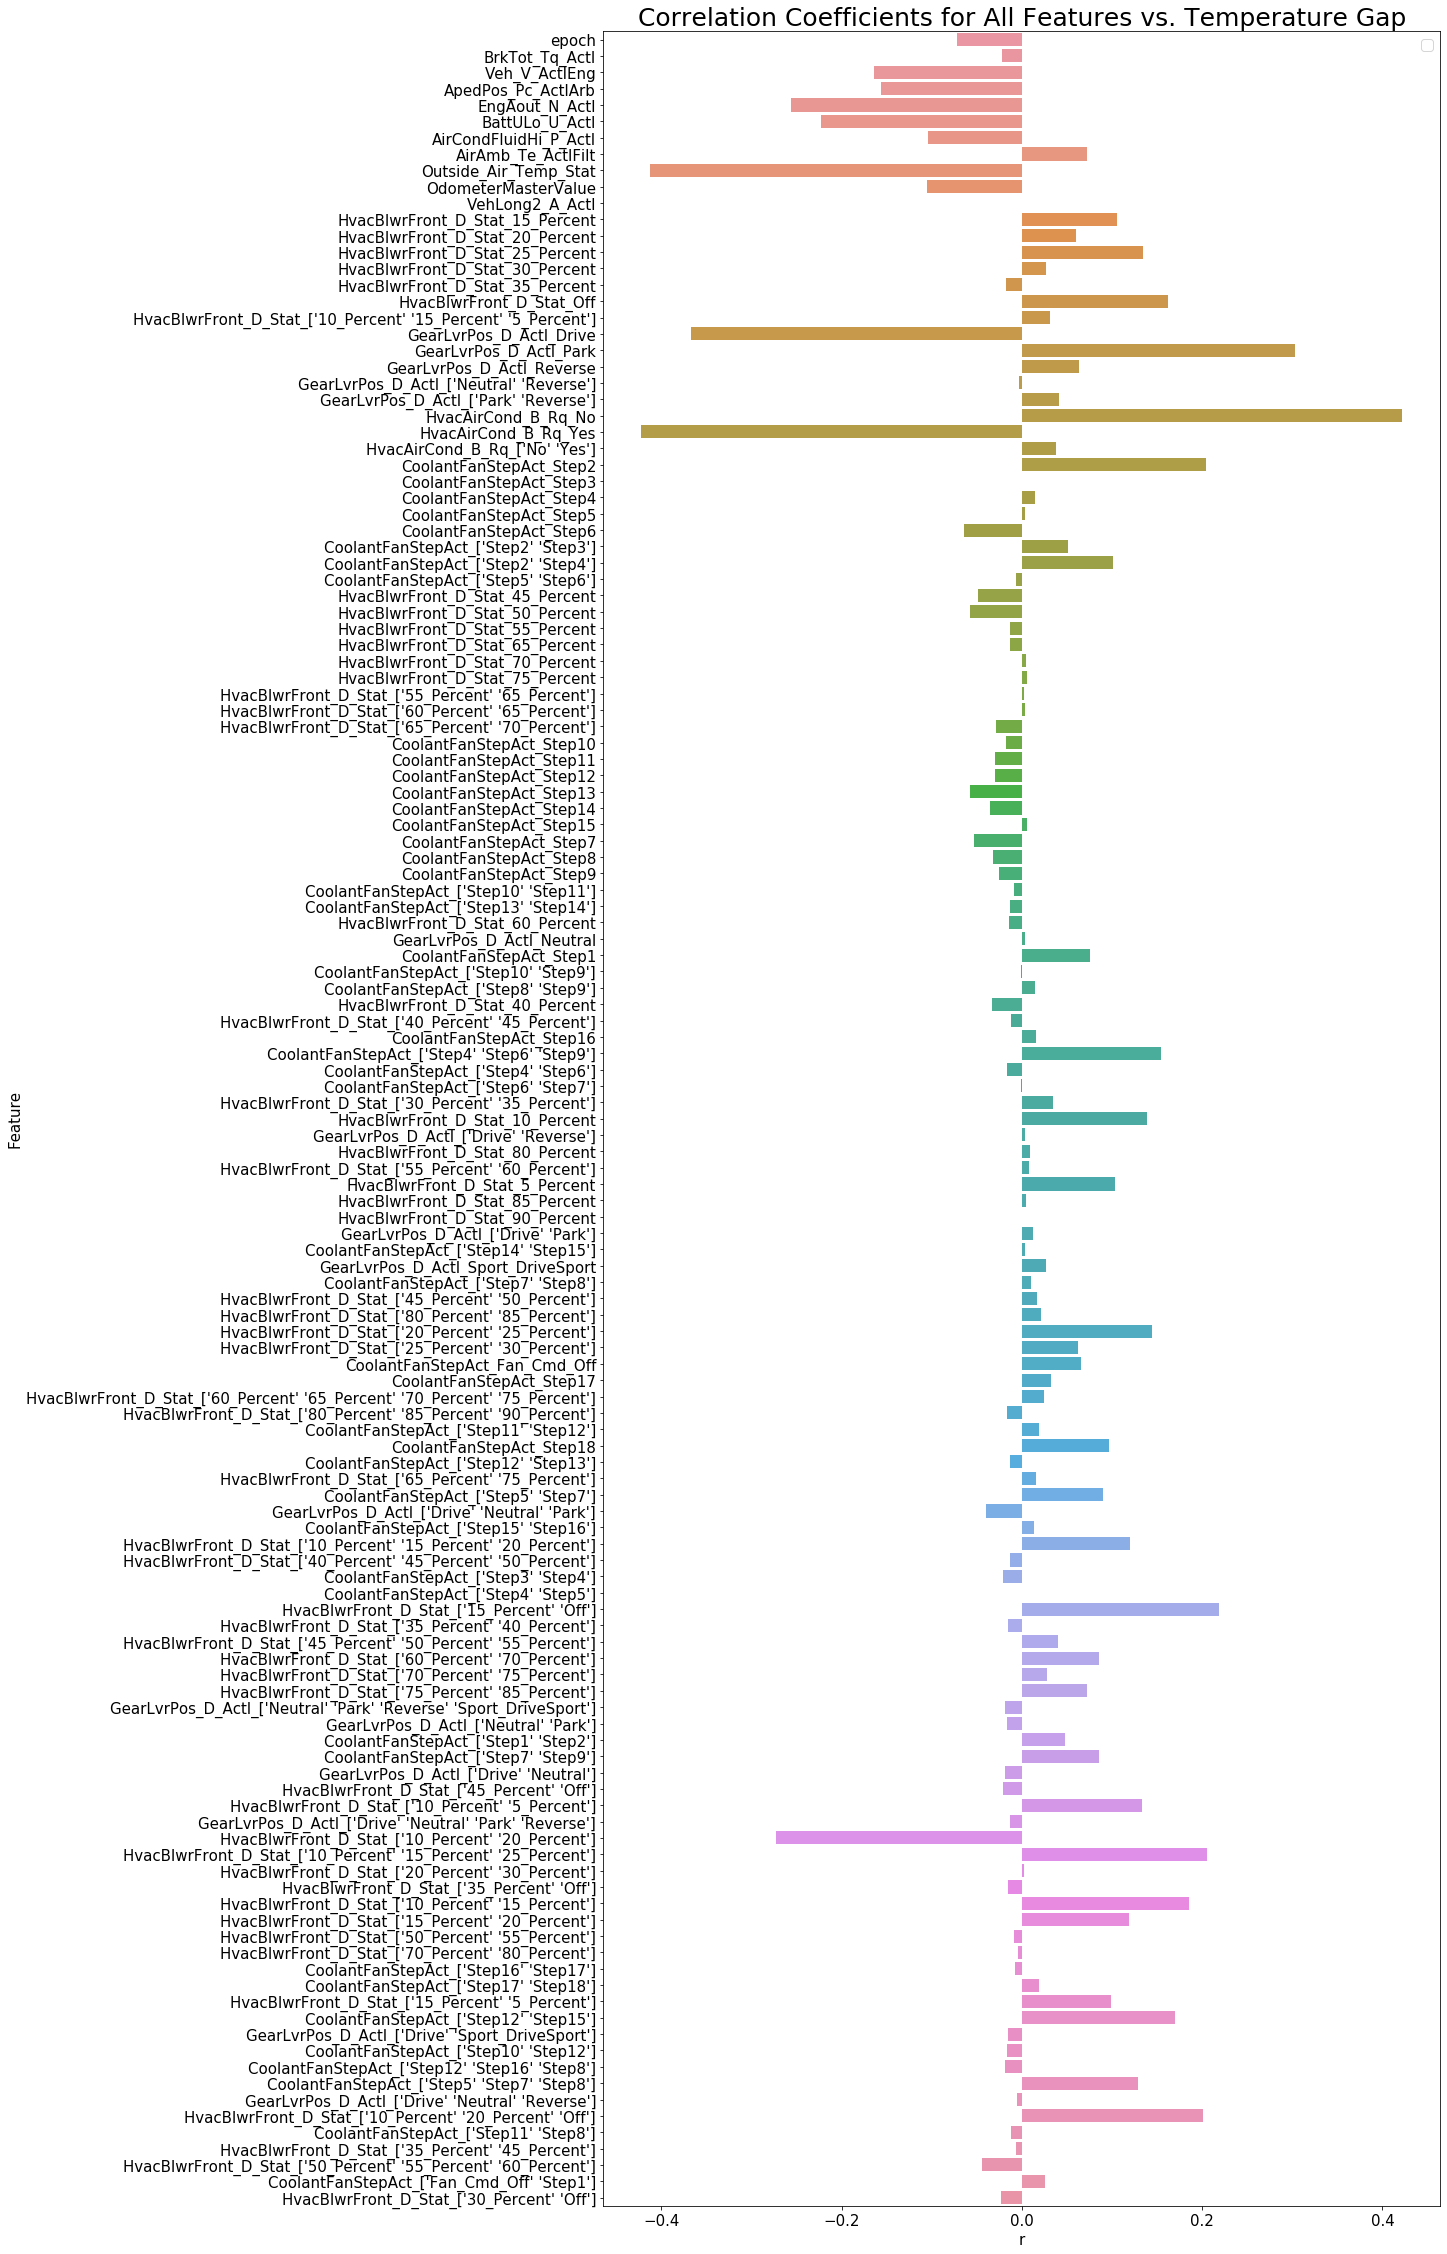

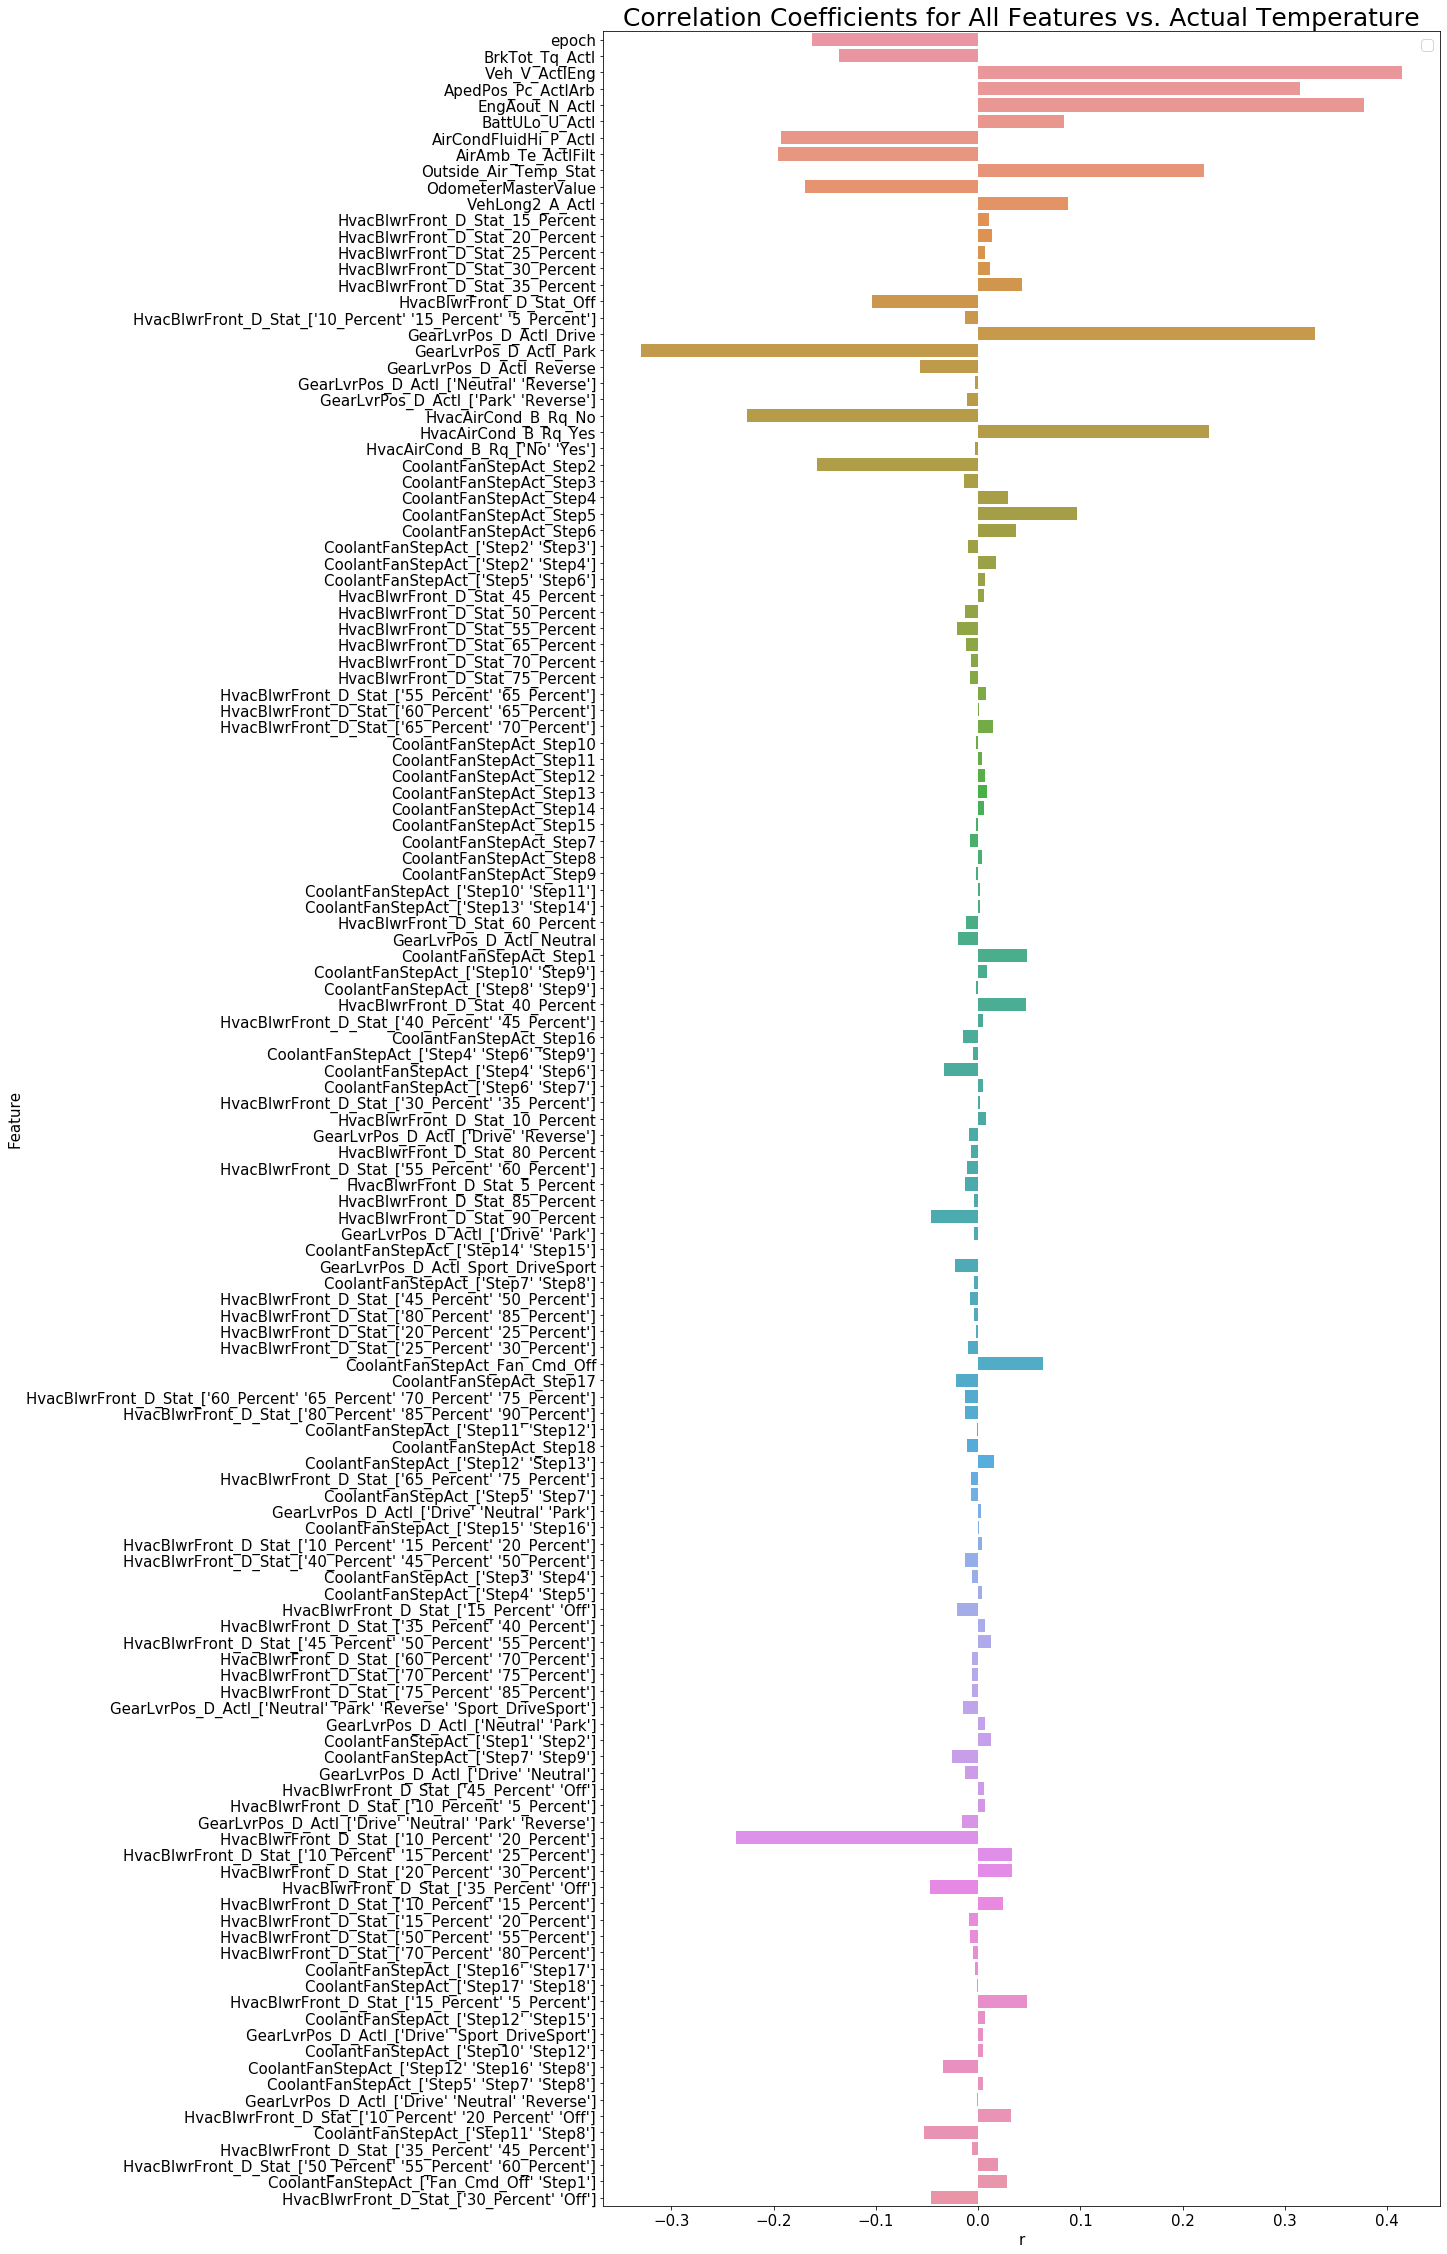

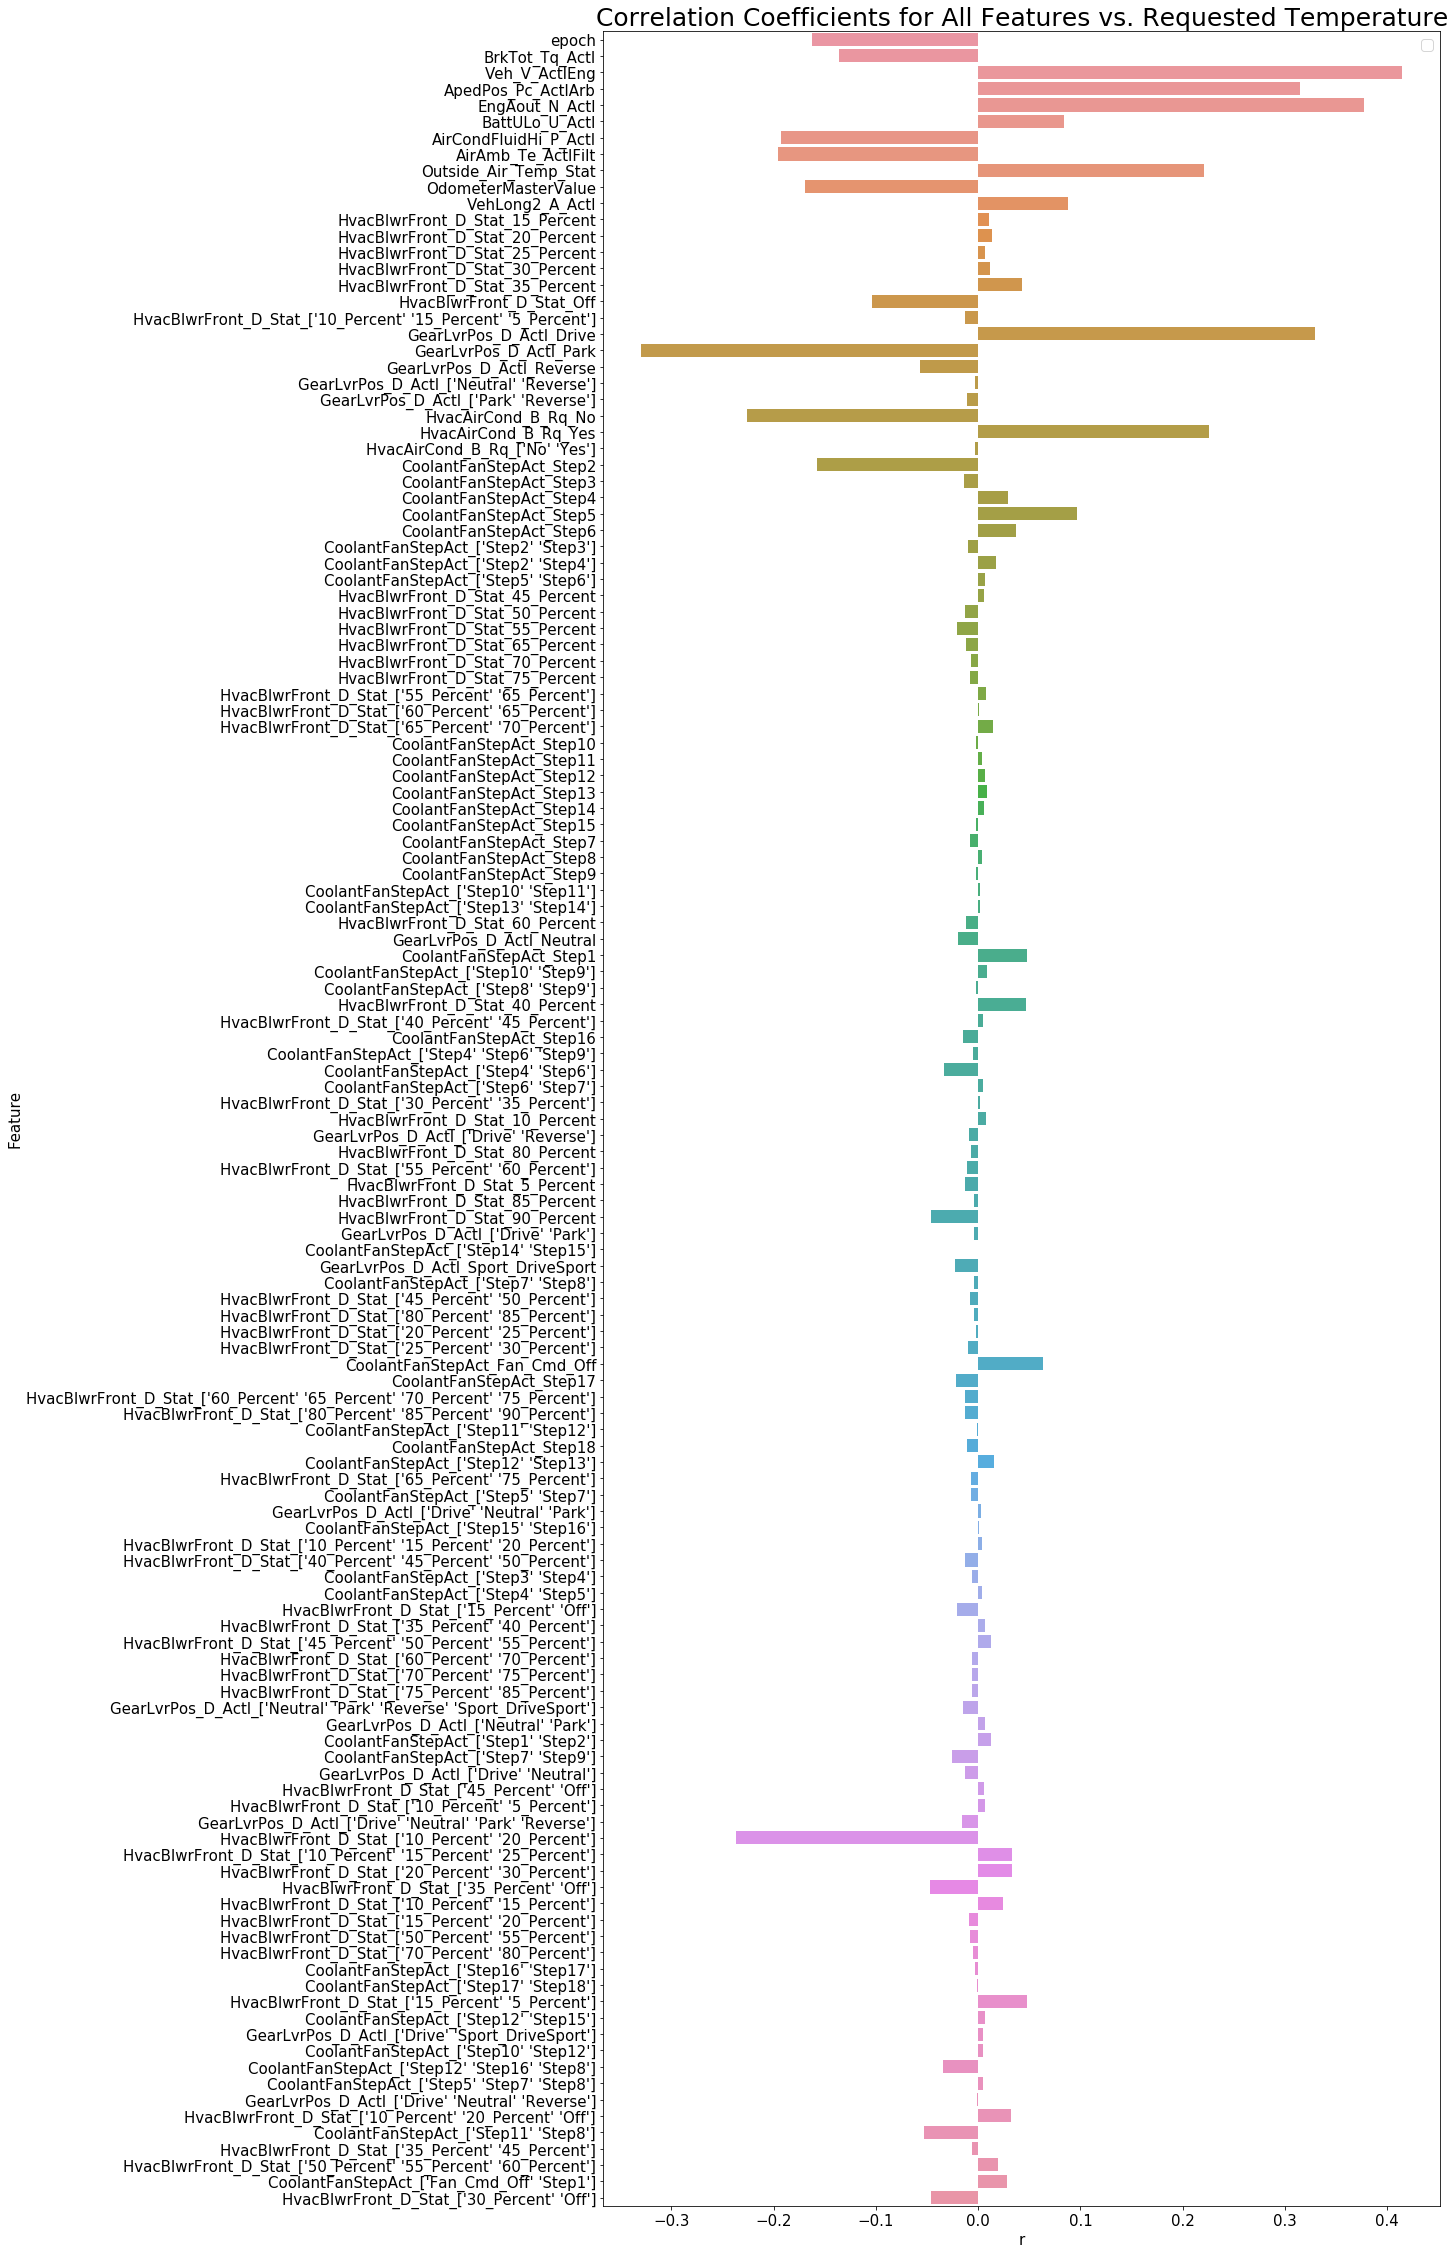

In [227]:
make_barplot_agg_corr(corr_data_agg.iloc[0, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Temperature Gap', 'r', 'Feature')
make_barplot_agg_corr(corr_data_agg.iloc[1, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Actual Temperature', 'r', 'Feature')
make_barplot_agg_corr(corr_data_agg.iloc[1, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Requested Temperature', 'r', 'Feature')

In [230]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_heatmap(trip_num=pivotted['trip'].unique(), impute=['Y','N']):
    trip = pivotted[pivotted['trip'] == trip_num]
    trip = trip[list(trip.columns[4:])]
    if impute == 'Y':
        trip[cols_to_ffill] = trip[cols_to_ffill].fillna(method='ffill')
        trip = make_dummies_and_impute(trip_num)
    else:
        trip = pd.get_dummies(trip)
    corr_matrix = trip.corr()
    f, ax = plt.subplots(figsize=(5, 15)) 
    heatmap = sns.heatmap(corr_matrix.loc[['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], :].transpose().drop(['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'OdometerMasterValue']), linewidths=0.5, annot=True)

interactive(children=(Dropdown(description='trip_num', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [232]:
@interact
def show_rel(impute=['Y', 'N'], trip_num=pivotted['trip'].unique(), feature=corr_data_agg.columns[1:], feature_unit=''):
    trip = pivotted[pivotted['trip'] == trip_num]
    trip = trip[['epoch'] + list(trip.columns[4:])]
    if impute == 'Y':
        trip[cols_to_ffill] = trip[cols_to_ffill].fillna(method='ffill')
        trip = make_dummies_and_impute(trip_num)
    else:
        trip = pd.get_dummies(trip)
    try:
        plot_rel(trip, str(feature), f'{feature} vs. Temperature', f'{feature} ({feature_unit})', 'Temperature (C)')
    except KeyError:
        print('Feature not present in trip, or trying to plot temperature with itself!')

interactive(children=(Dropdown(description='impute', options=('Y', 'N'), value='Y'), Dropdown(description='tri…

<a id='dur_neg'></a>
**2) Duration that Internal Compressor Temperature is < 0°C**

Let's begin by imputing missing values using a combination of forward filling and KNN, as done above when answering the first question.

In [410]:
trip37[trip37['HvacAirCond_B_Rq_Yes'] == 1]['HvacEvap_Te_Rq'].unique()

array([2.])

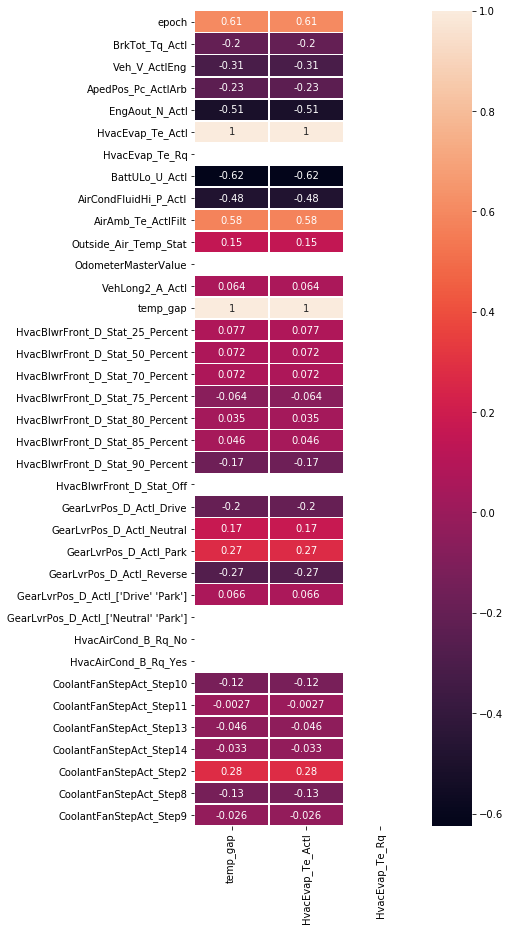

In [407]:

f, ax = plt.subplots(figsize=(5, 15)) 
heatmap = sns.heatmap(trip37[trip37['HvacAirCond_B_Rq_Yes'] == 1].corr().loc[['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], :].transpose(), linewidths=0.5, annot=True)

In [357]:
pivotted['HvacEvap_Te_Actl_sign'] = pivotted['HvacEvap_Te_Actl'].map(np.sign) # col to keep track of sign

neg_temp_intervals = []
for trip in pivotted['trip'].unique():
    temp = pivotted[pivotted['trip'] == trip]
    for i, g in temp.groupby([(pivotted['HvacEvap_Te_Actl_sign'] != pivotted['HvacEvap_Te_Actl_sign'].shift()).cumsum()]):
        if g.loc[g.index[0], 'HvacEvap_Te_Actl_sign'] == -1:
            neg_temp_intervals.append(g)
neg_temp_intervals.sort(key=lambda x: x['epoch'].max() - x['epoch'].min())

C:\Users\achopra8\Anaconda3\lib\site-packages\pandas\core\base.py:1154: RuntimeWarning: invalid value encountered in sign
  new_values = map_f(values, mapper)


DescribeResult(nobs=60, minmax=(0.0, 7.0), mean=1.8333333333333333, variance=3.429378531073447, skewness=0.9566348571045651, kurtosis=0.16452209125279138)


Text(0, 0.5, 'Density')

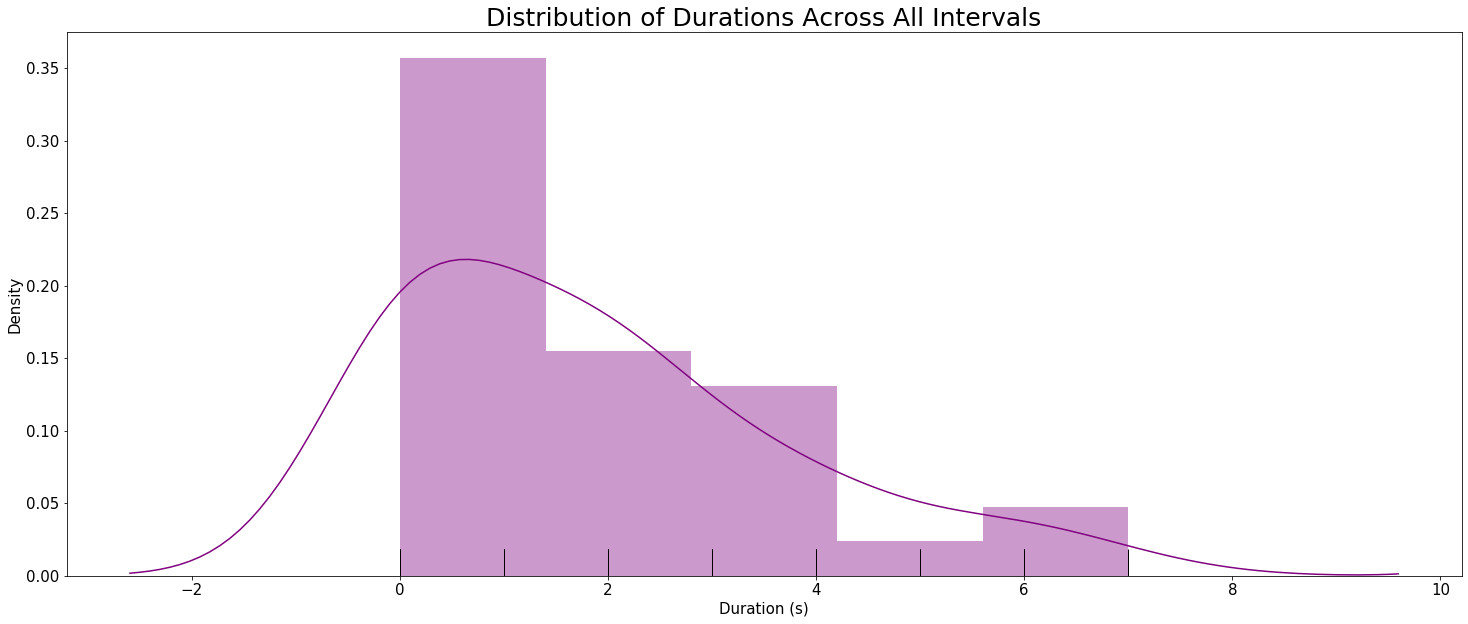

In [366]:
time_elap = [interval['epoch'].max() - interval['epoch'].min() for interval in neg_temp_intervals]
print(describe(time_elap))

fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Durations Across All Intervals', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)